In [1]:
import random
import torch
from torch import nn
from torch import optim
import numpy as np

In [2]:
import sys
sys.path.append('/kaggle/input/nma-util/util')

In [3]:
def set_seed(seed=None, seed_torch=True):
    """
    Function that controls randomness. NumPy and random modules must be imported.

    Args:
      seed : Integer
        A non-negative integer that defines the random state. Default is `None`.
      seed_torch : Boolean
        If `True` sets the random seed for pytorch tensors, so pytorch module
        must be imported. Default is `True`.

    Returns:
      Nothing.
    """
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')

In [4]:
set_seed(1)

Random seed 1 has been set.


## Step 1: Setup You Tokenizer 


In [5]:
from transformers import XLMRobertaTokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

## Step 2: Get DataLoaders

In [6]:
from data_pipeline import get_data_loaders

english_train_loader, english_validation_loader, target_validation_loader, target_test_loader = get_data_loaders(tokenizer, presentage=0.5,
                                                                                                                 batch_size=512, max_length=128)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/99.1M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/393435 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/393436 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Filter:   0%|          | 0/393435 [00:00<?, ? examples/s]

Filter:   0%|          | 0/393436 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3147478 [00:00<?, ? examples/s]

Filter:   0%|          | 0/393435 [00:00<?, ? examples/s]

Filter:   0%|          | 0/393436 [00:00<?, ? examples/s]

## Step 3: Load The Model

In [7]:
from transformers import XLMRobertaModel

# Load pretrained multilingual BERT model
model = XLMRobertaModel.from_pretrained("xlm-roberta-base")

# -------------------------------
# Freeze embedding layer
# -------------------------------
for param in model.embeddings.parameters():
    param.requires_grad = False
# -------------------------------
# Keep only the first 6 encoder layers
# -------------------------------
model.encoder.layer = model.encoder.layer[:6]

# -------------------------------
# Reinitialize all weights in the encoder layers (6 layers)
# -------------------------------
for layer in model.encoder.layer:
    for module in layer.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

2025-07-24 08:38:17.239067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753346297.430198      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753346297.489291      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## Step 4: Setup The Model

In [8]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertSentimentClassifier, self).__init__()
        self.bert = bert_model
        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        # Add a fully connected layer for classification
        # The output dimension of BERT's [CLS] token is usually the hidden size
        # which is 768 for bert-base-multilingual-uncased
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None):
        # Get the output from the BERT model
        # We only need the [CLS] token representation for classification
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        # Get the hidden states of the [CLS] token (first token)
        cls_representation = outputs.last_hidden_state[:, 0, :]
        # Apply dropout
        cls_representation = self.dropout(cls_representation)
        # Pass the [CLS] representation through the classifier
        logits = self.classifier(cls_representation)
        return logits

# Instantiate the classifier
# Assuming the dataset has 3 classes: positive, neutral, negative
num_classes = 3
sentiment_classifier = BertSentimentClassifier(model, num_classes)

sentiment_classifier

BertSentimentClassifier(
  (bert): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
 

## Step 4: Setup Training Hyperparameters & Optimizer

In [9]:
# Training hyperparameters
learning_rate = 2e-4  # Common learning rate for fine-tuning BERT
num_epochs = 10        # Typical for BERT fine-tuning

# Setup optimizer
# Use AdamW optimizer which is recommended for transformers
optimizer = optim.AdamW(
    sentiment_classifier.parameters(),
    lr=learning_rate
)

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=2e-5)  # eta_min is optional

In [11]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentiment_classifier.to(device)

BertSentimentClassifier(
  (bert): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
 

## Step 6: Setup The Trainer

In [12]:
from model_trainer import ModelTrainer

trainer = ModelTrainer(sentiment_classifier, optimizer, device, num_epochs, english_train_loader, english_validation_loader,
                       target_validation_loader, target_test_loader, scheduler)

In [13]:
history = trainer.train()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.6680, Acc: 0.7030, F1: 0.6999 | LR: 1.96e-04
  English Val - Loss: 0.5631, Acc: 0.7502, F1: 0.7482
  Target Val  - Loss: 1.0943, Acc: 0.6231, F1: 0.5056


Training Epoch 2:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.5491, Acc: 0.7580, F1: 0.7552 | LR: 1.83e-04
  English Val - Loss: 0.5344, Acc: 0.7654, F1: 0.7619
  Target Val  - Loss: 1.2597, Acc: 0.6351, F1: 0.4969


Training Epoch 3:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.5168, Acc: 0.7738, F1: 0.7710 | LR: 1.63e-04
  English Val - Loss: 0.5353, Acc: 0.7668, F1: 0.7637
  Target Val  - Loss: 1.3053, Acc: 0.6460, F1: 0.4939


Training Epoch 4:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.4906, Acc: 0.7864, F1: 0.7839 | LR: 1.38e-04
  English Val - Loss: 0.5156, Acc: 0.7752, F1: 0.7733
  Target Val  - Loss: 1.3227, Acc: 0.6398, F1: 0.4999


Training Epoch 5:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.4625, Acc: 0.7997, F1: 0.7972 | LR: 1.10e-04
  English Val - Loss: 0.5276, Acc: 0.7743, F1: 0.7723
  Target Val  - Loss: 1.5076, Acc: 0.6481, F1: 0.5000


Training Epoch 6:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.4304, Acc: 0.8144, F1: 0.8121 | LR: 8.22e-05
  English Val - Loss: 0.5308, Acc: 0.7761, F1: 0.7738
  Target Val  - Loss: 1.5518, Acc: 0.6259, F1: 0.4829


Training Epoch 7:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.3927, Acc: 0.8323, F1: 0.8301 | LR: 5.71e-05
  English Val - Loss: 0.5377, Acc: 0.7753, F1: 0.7732
  Target Val  - Loss: 1.7912, Acc: 0.6165, F1: 0.4713


Training Epoch 8:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.3526, Acc: 0.8508, F1: 0.8488 | LR: 3.72e-05
  English Val - Loss: 0.5959, Acc: 0.7746, F1: 0.7717
  Target Val  - Loss: 2.0429, Acc: 0.6175, F1: 0.4903


Training Epoch 9:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.3161, Acc: 0.8670, F1: 0.8652 | LR: 2.44e-05
  English Val - Loss: 0.6412, Acc: 0.7710, F1: 0.7688
  Target Val  - Loss: 2.3833, Acc: 0.6168, F1: 0.4807


Training Epoch 10:   0%|          | 0/1188 [00:00<?, ?it/s]

Evaluating English Val:   0%|          | 0/149 [00:00<?, ?it/s]

Evaluating Target Val:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.2879, Acc: 0.8797, F1: 0.8780 | LR: 2.00e-05
  English Val - Loss: 0.6866, Acc: 0.7663, F1: 0.7647
  Target Val  - Loss: 2.5241, Acc: 0.6157, F1: 0.4803
Training history saved to checkpoints/training_history.json


## Step 7: Plotting & Saving Graphs

In [14]:
from visualizer import TrainingVisualizer

training_visualizer = TrainingVisualizer()

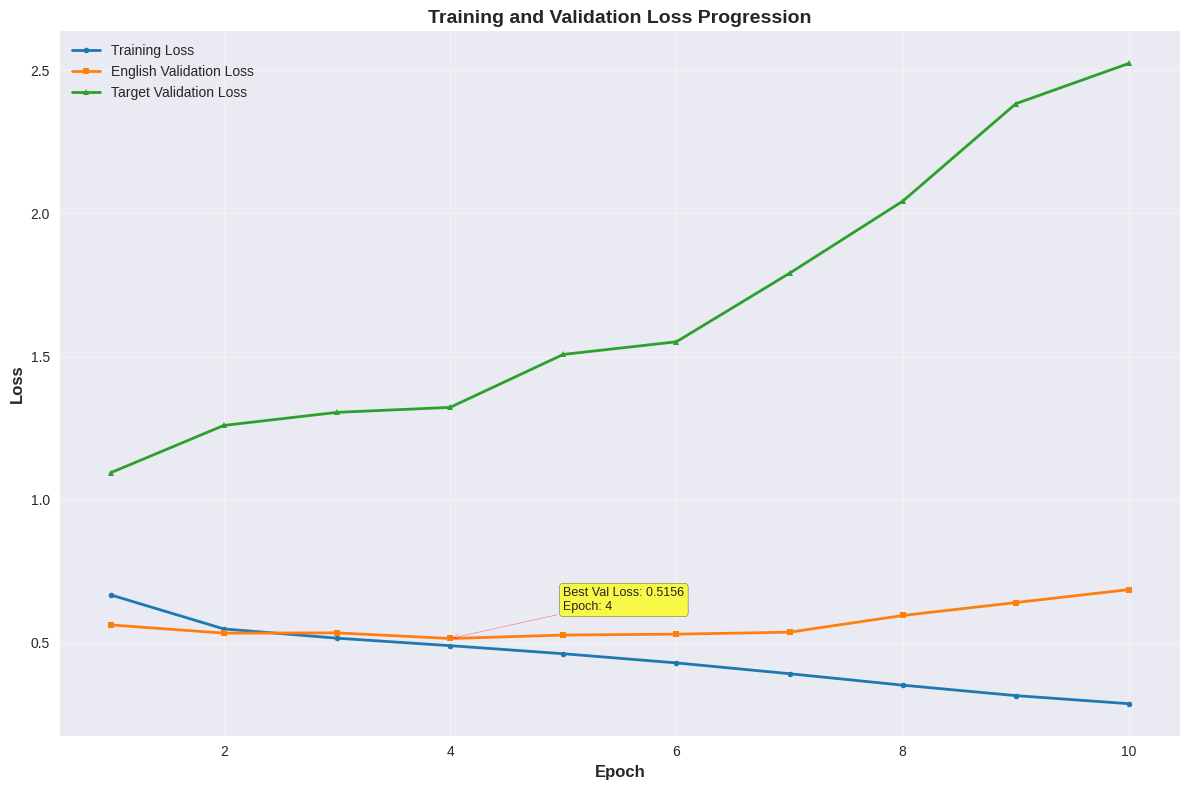

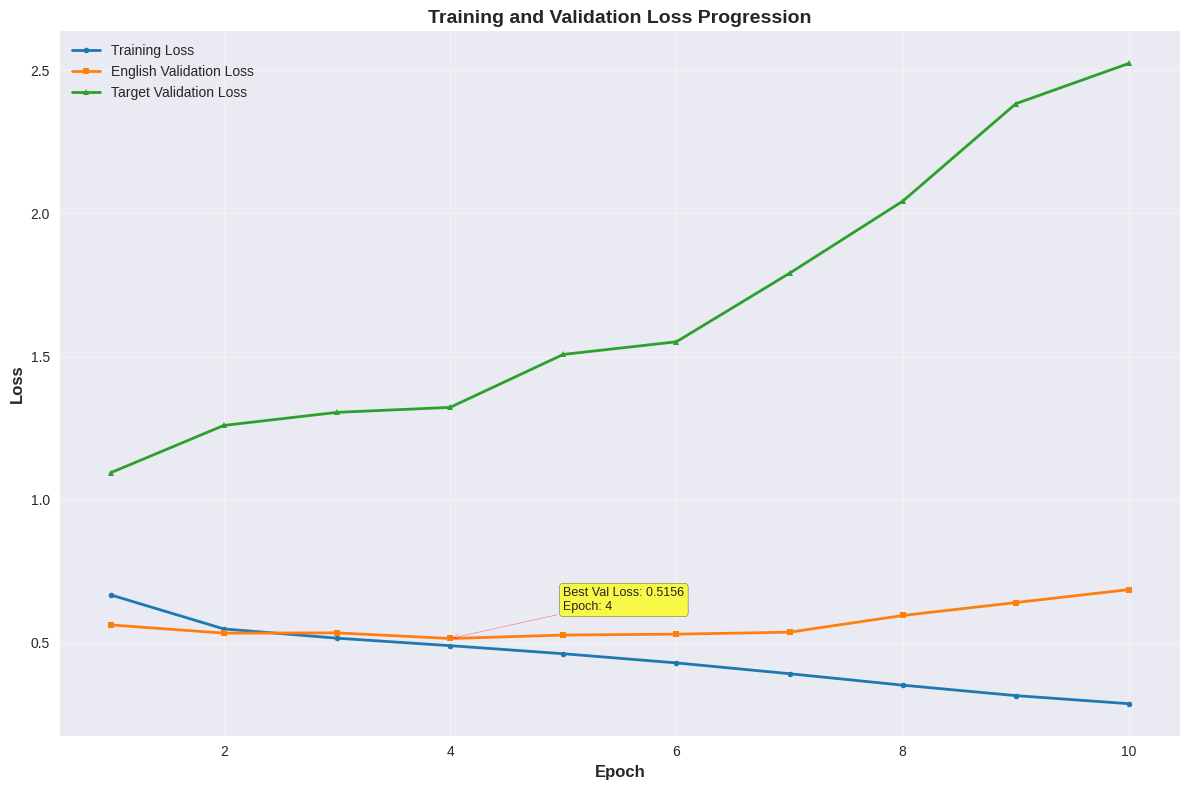

In [15]:
training_visualizer.plot_losses(history)

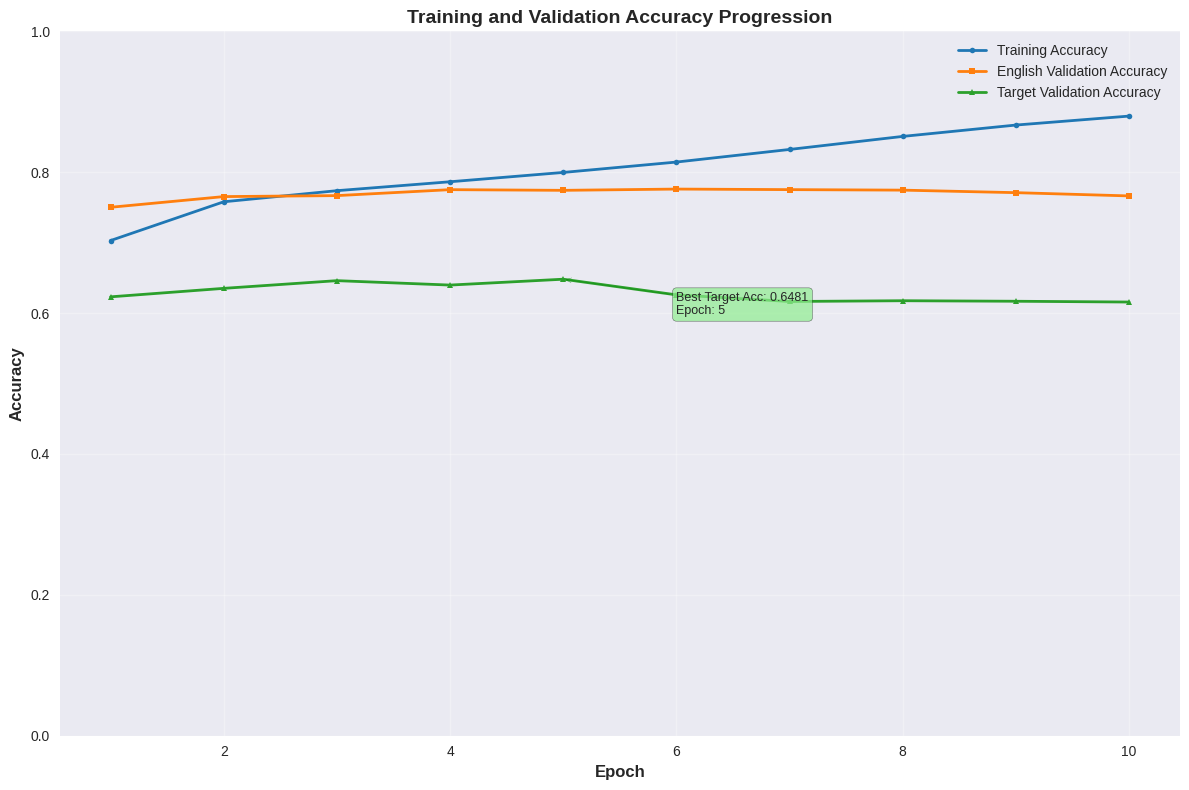

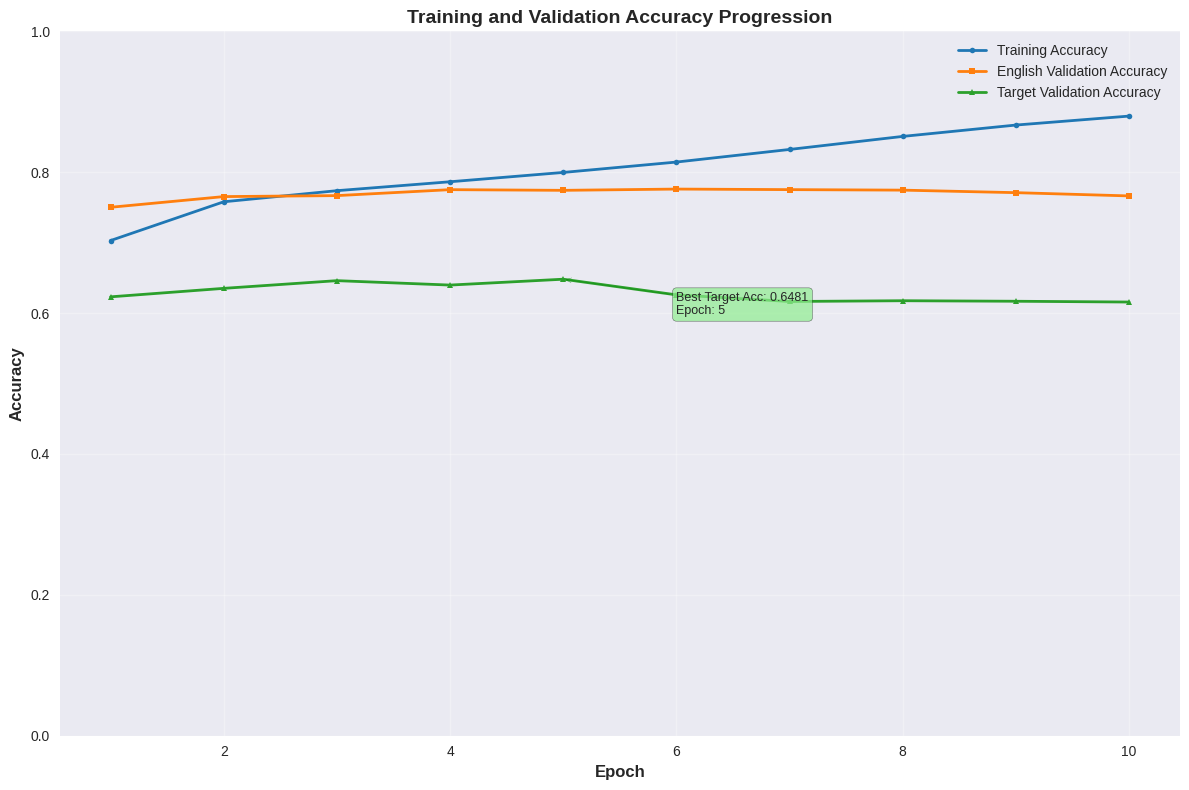

In [16]:
training_visualizer.plot_accuracies(history)

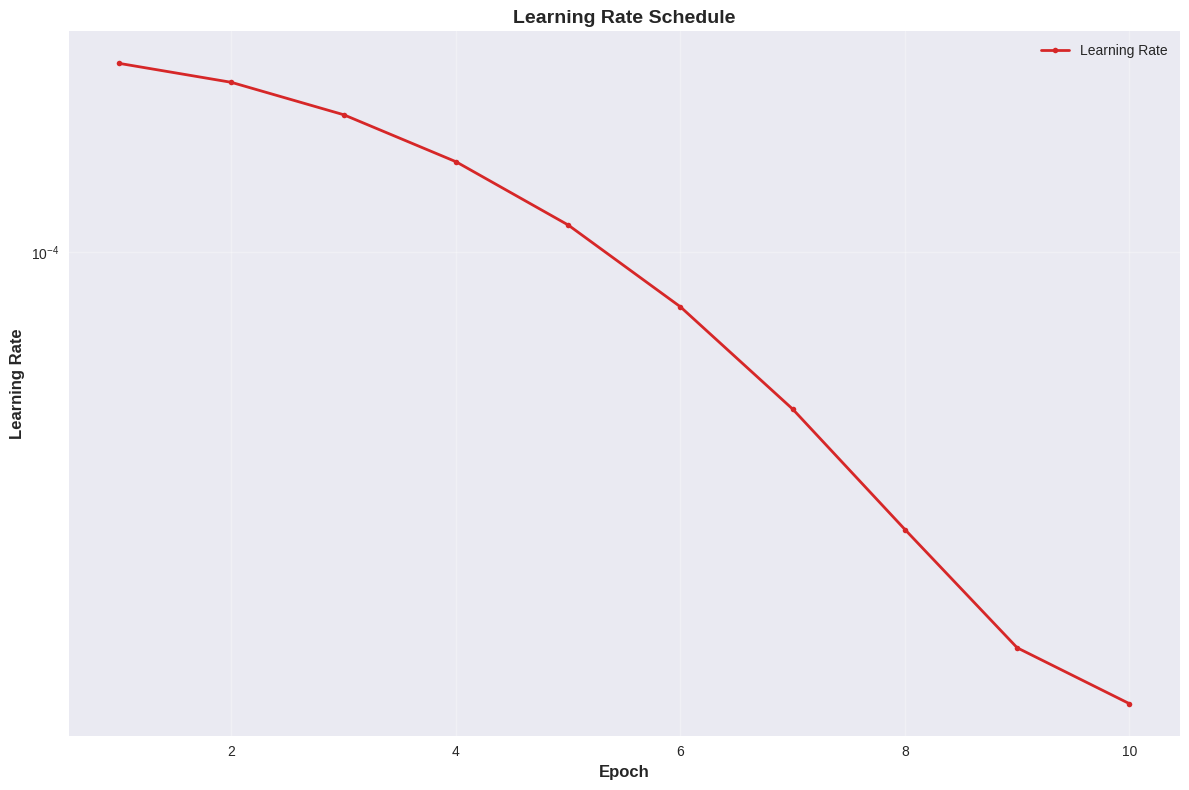

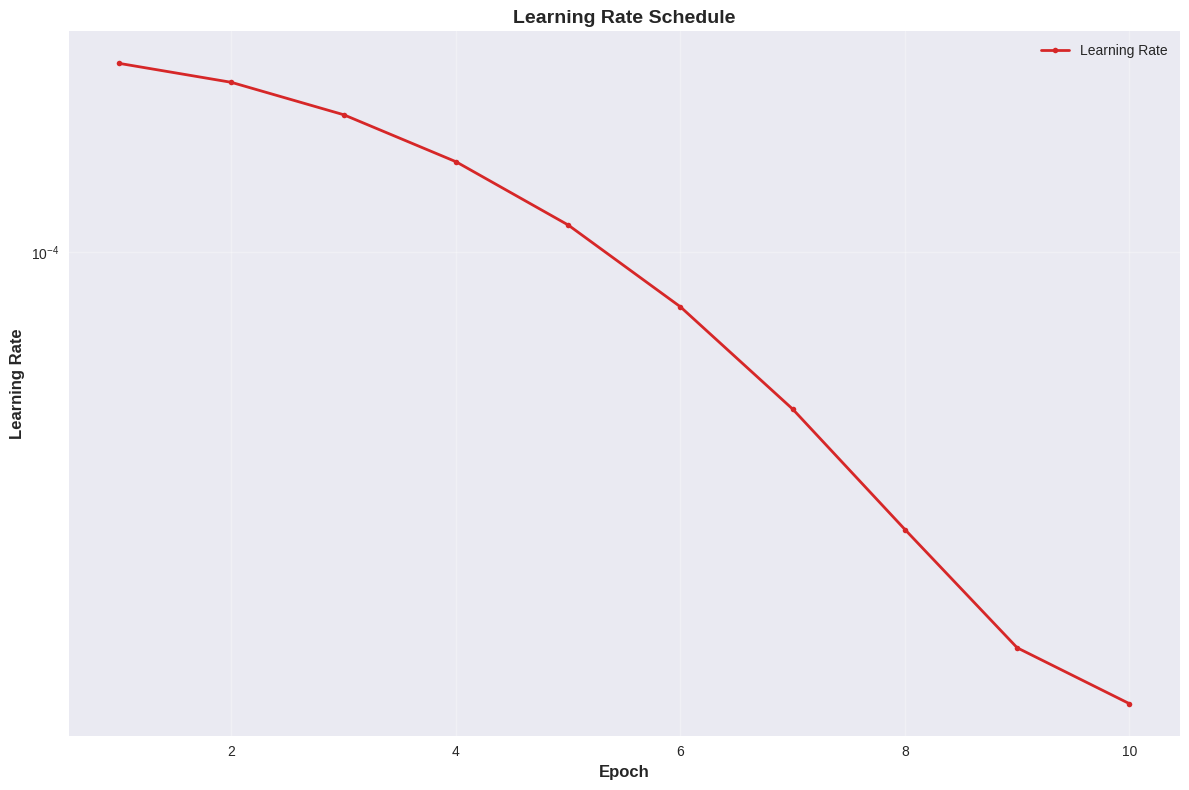

In [17]:
training_visualizer.plot_learning_rate(history)

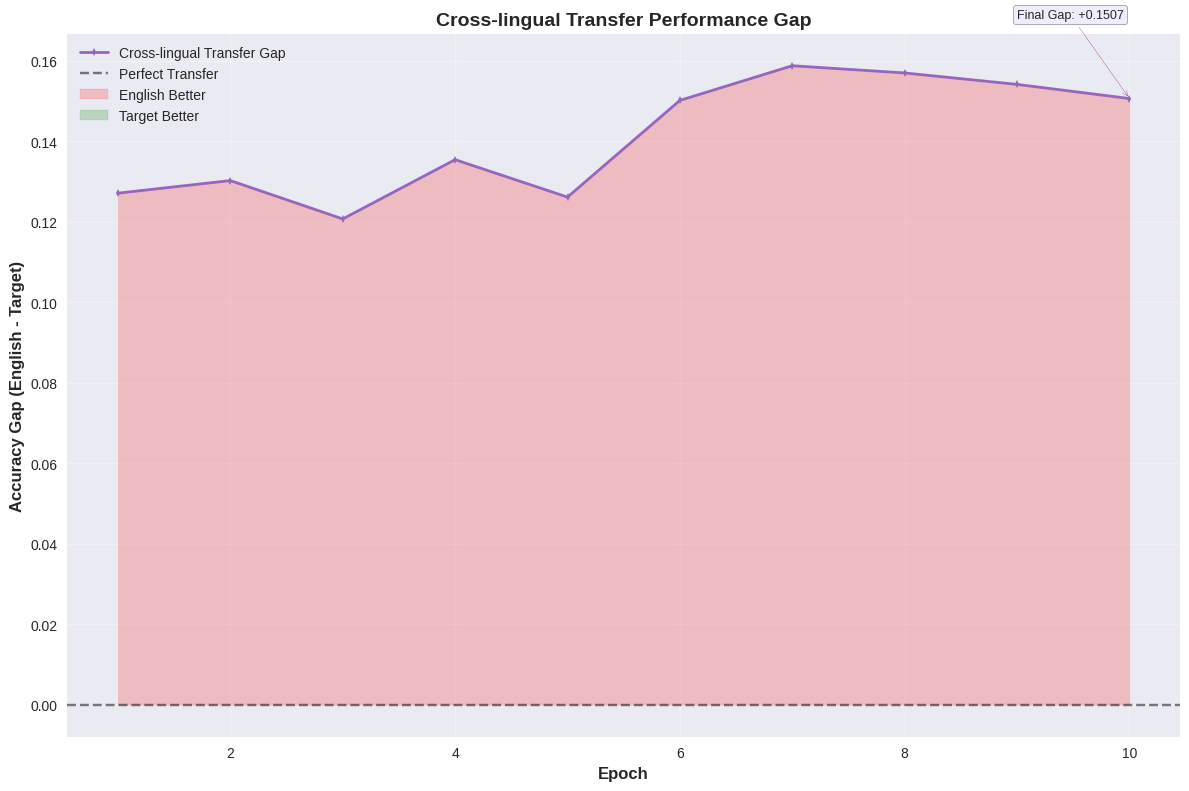

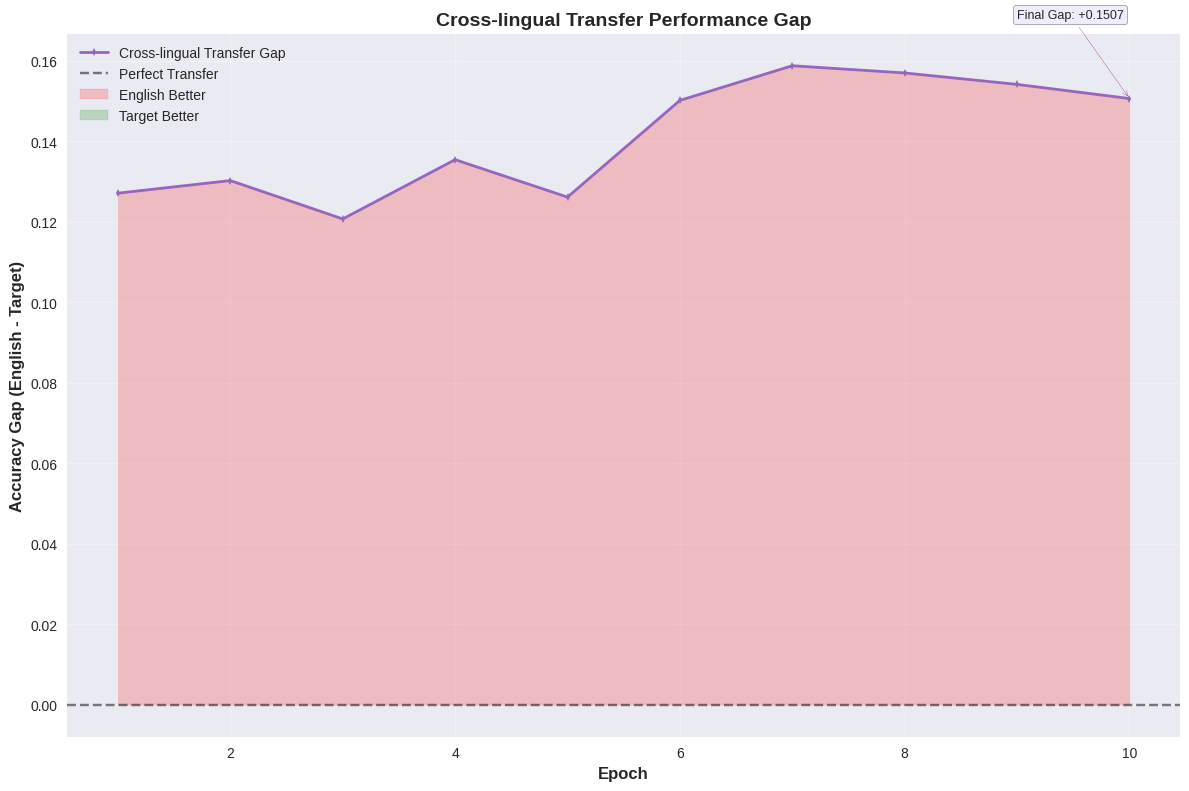

In [18]:
training_visualizer.plot_transfer_gap(history)

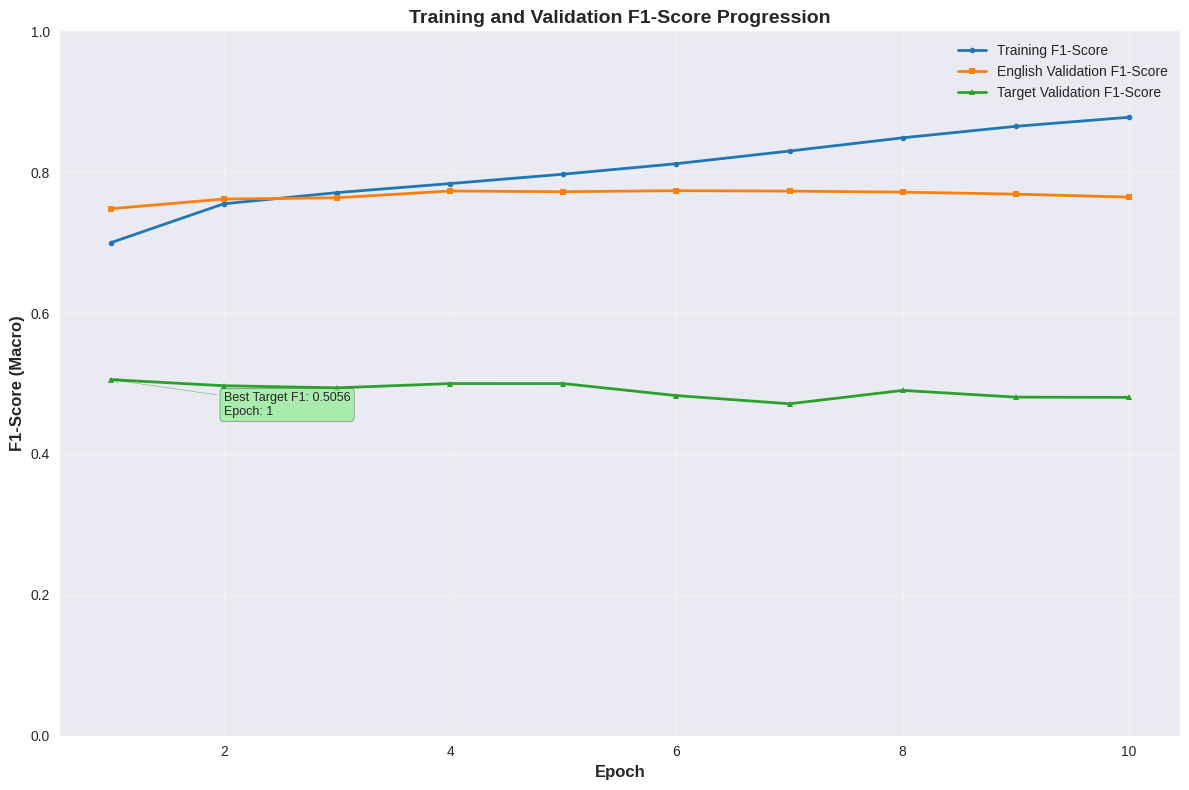

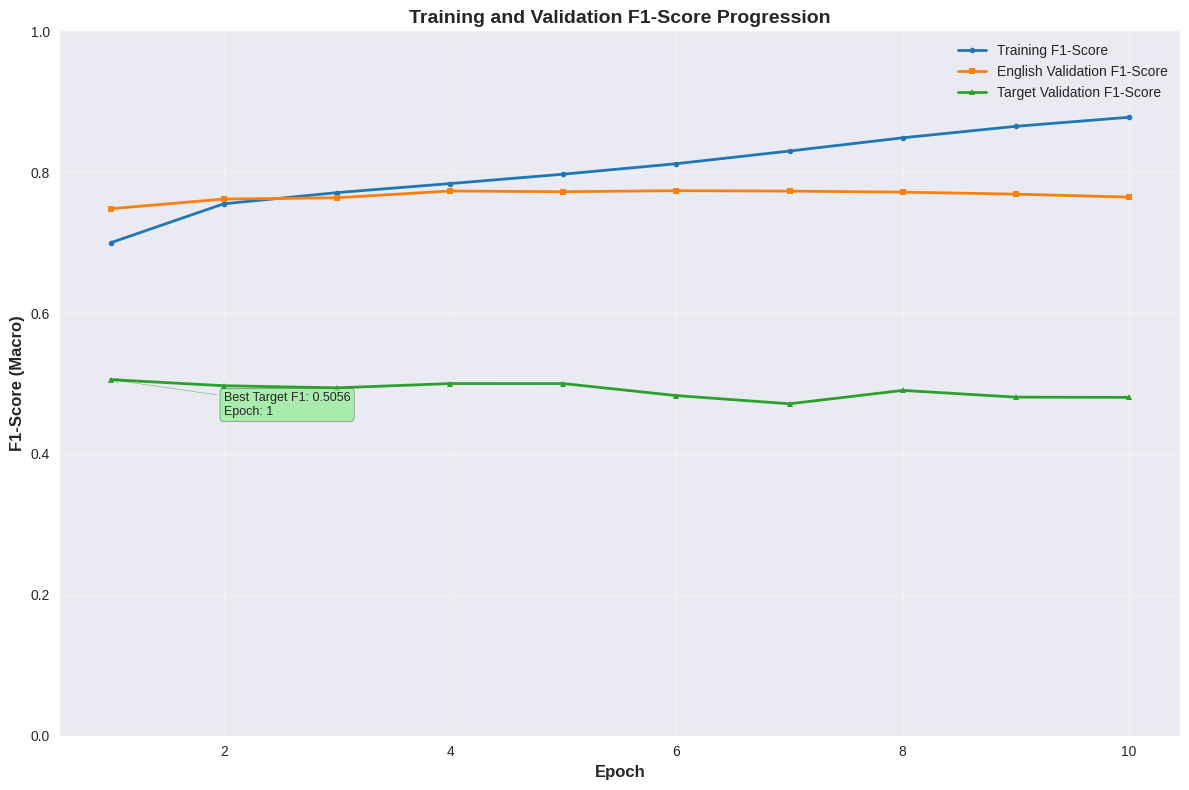

In [19]:
training_visualizer.plot_f1_scores(history)

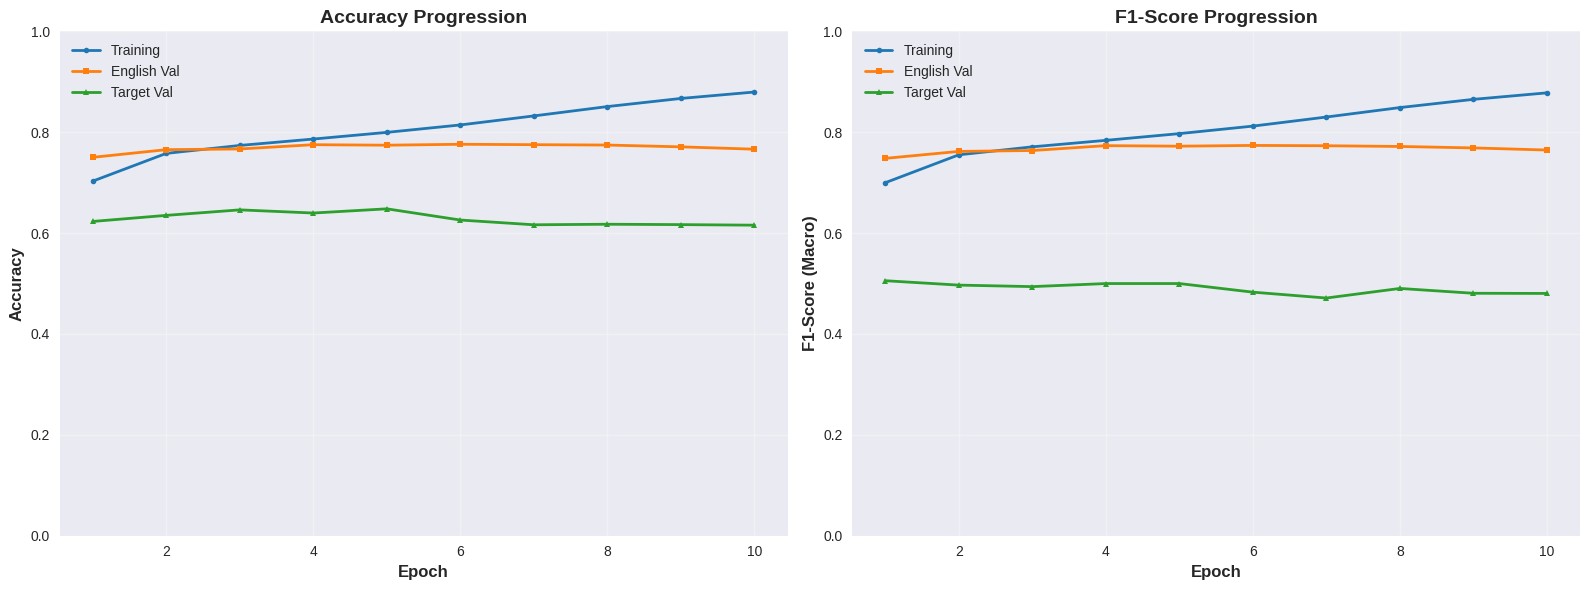

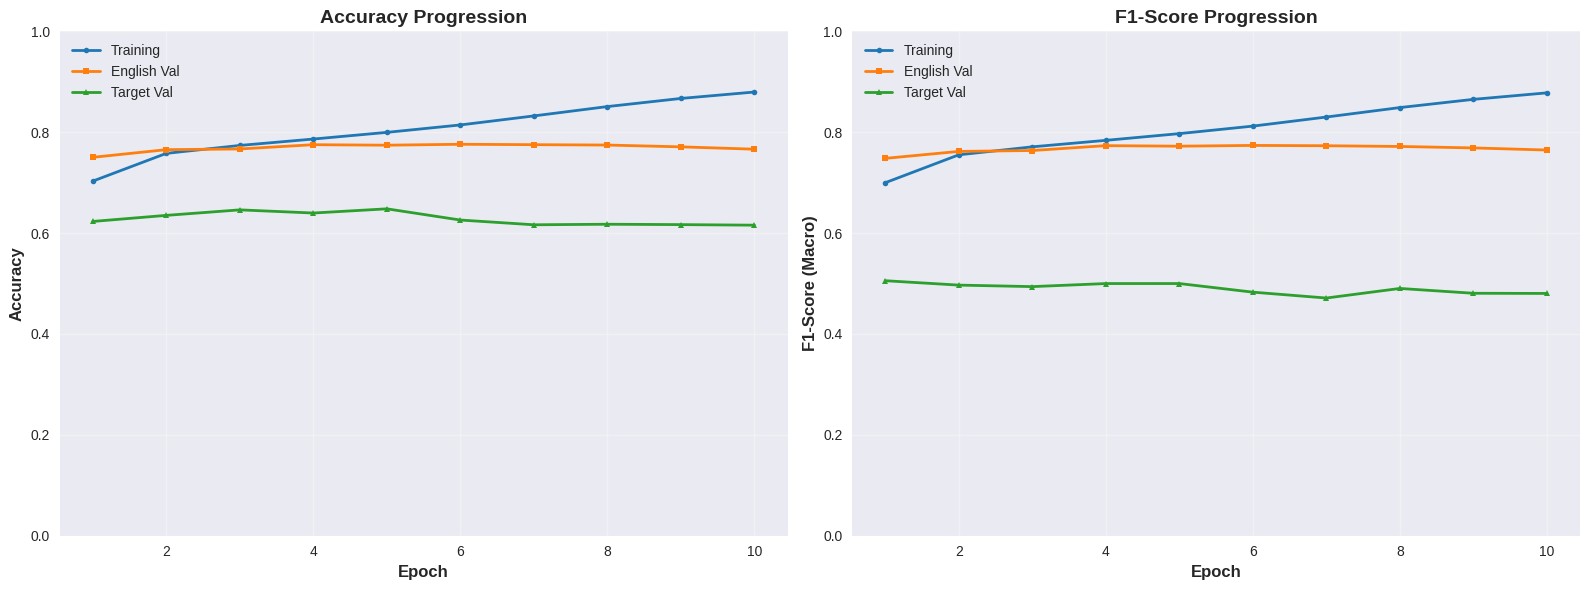

In [20]:
training_visualizer.plot_accuracy_f1_comparison(history)

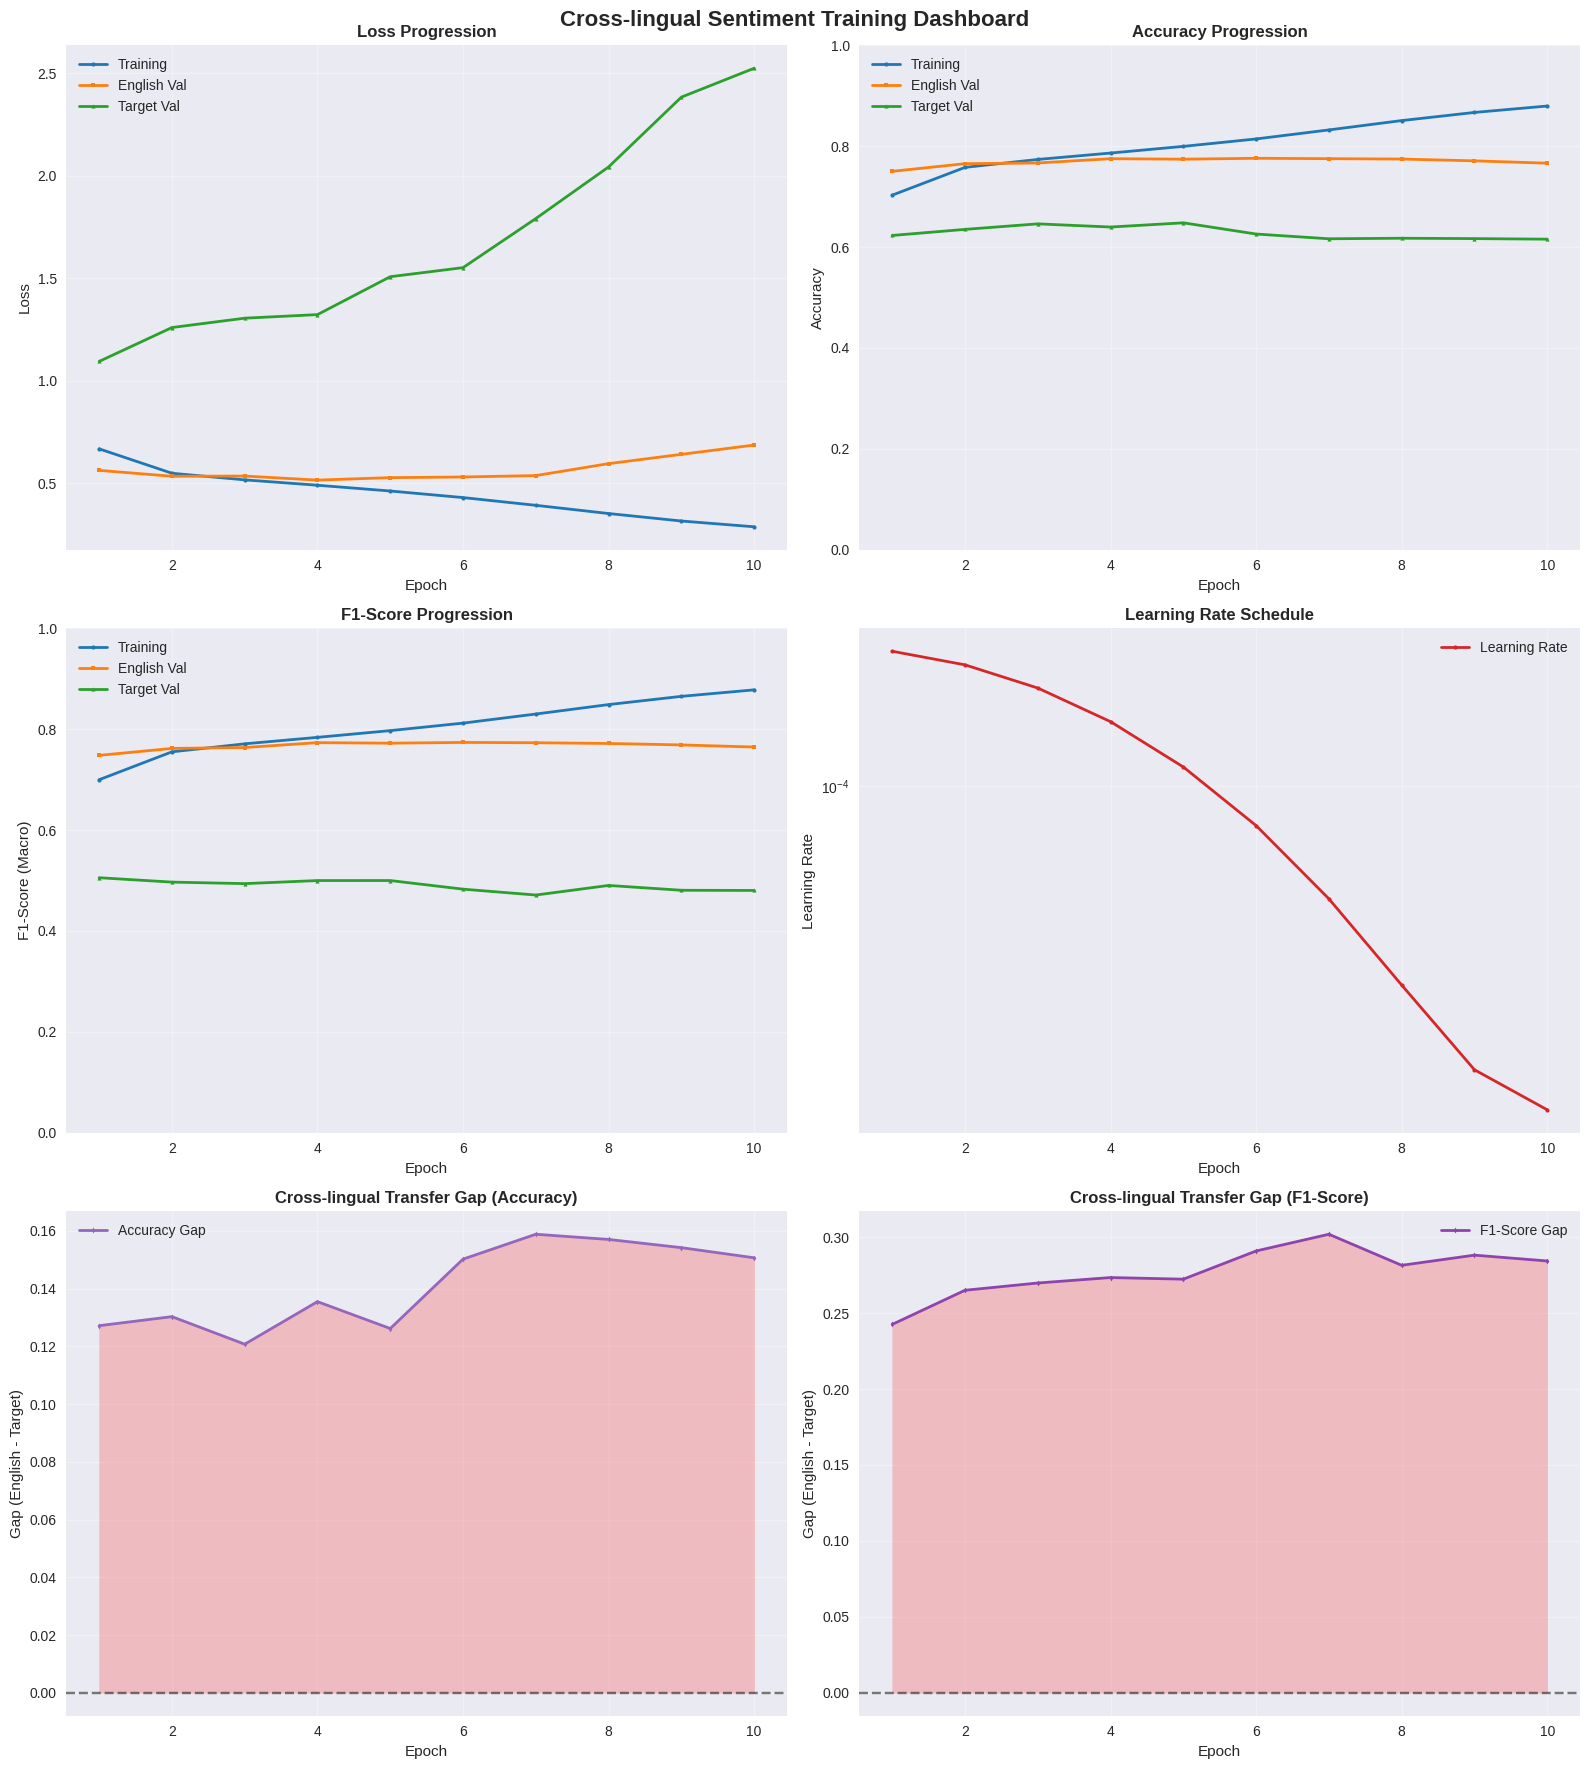

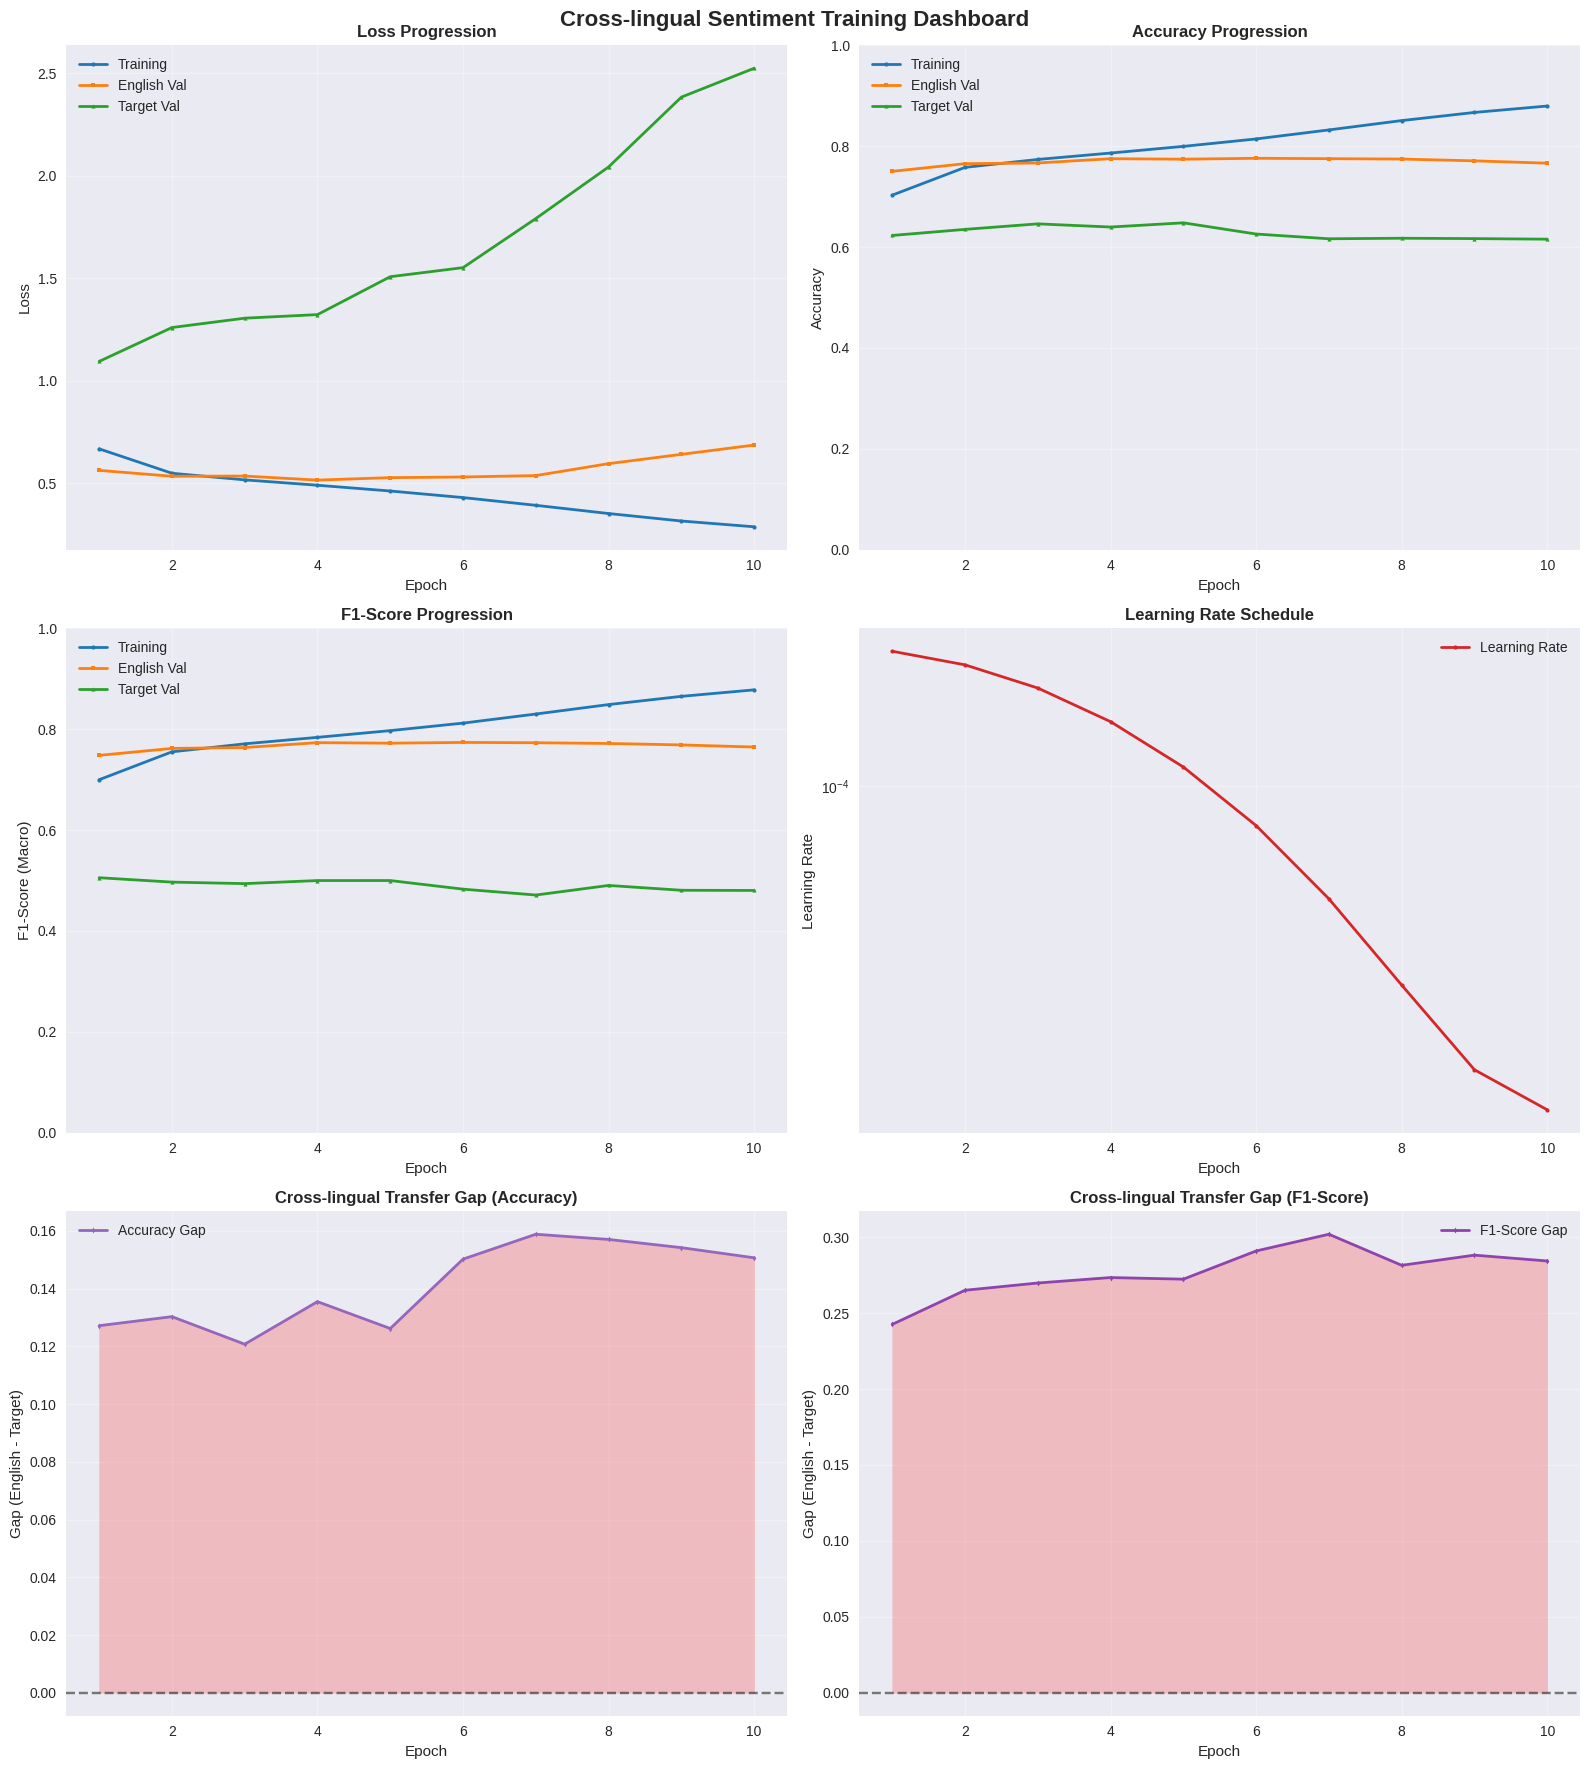

In [21]:
training_visualizer.plot_training_dashboard(history)

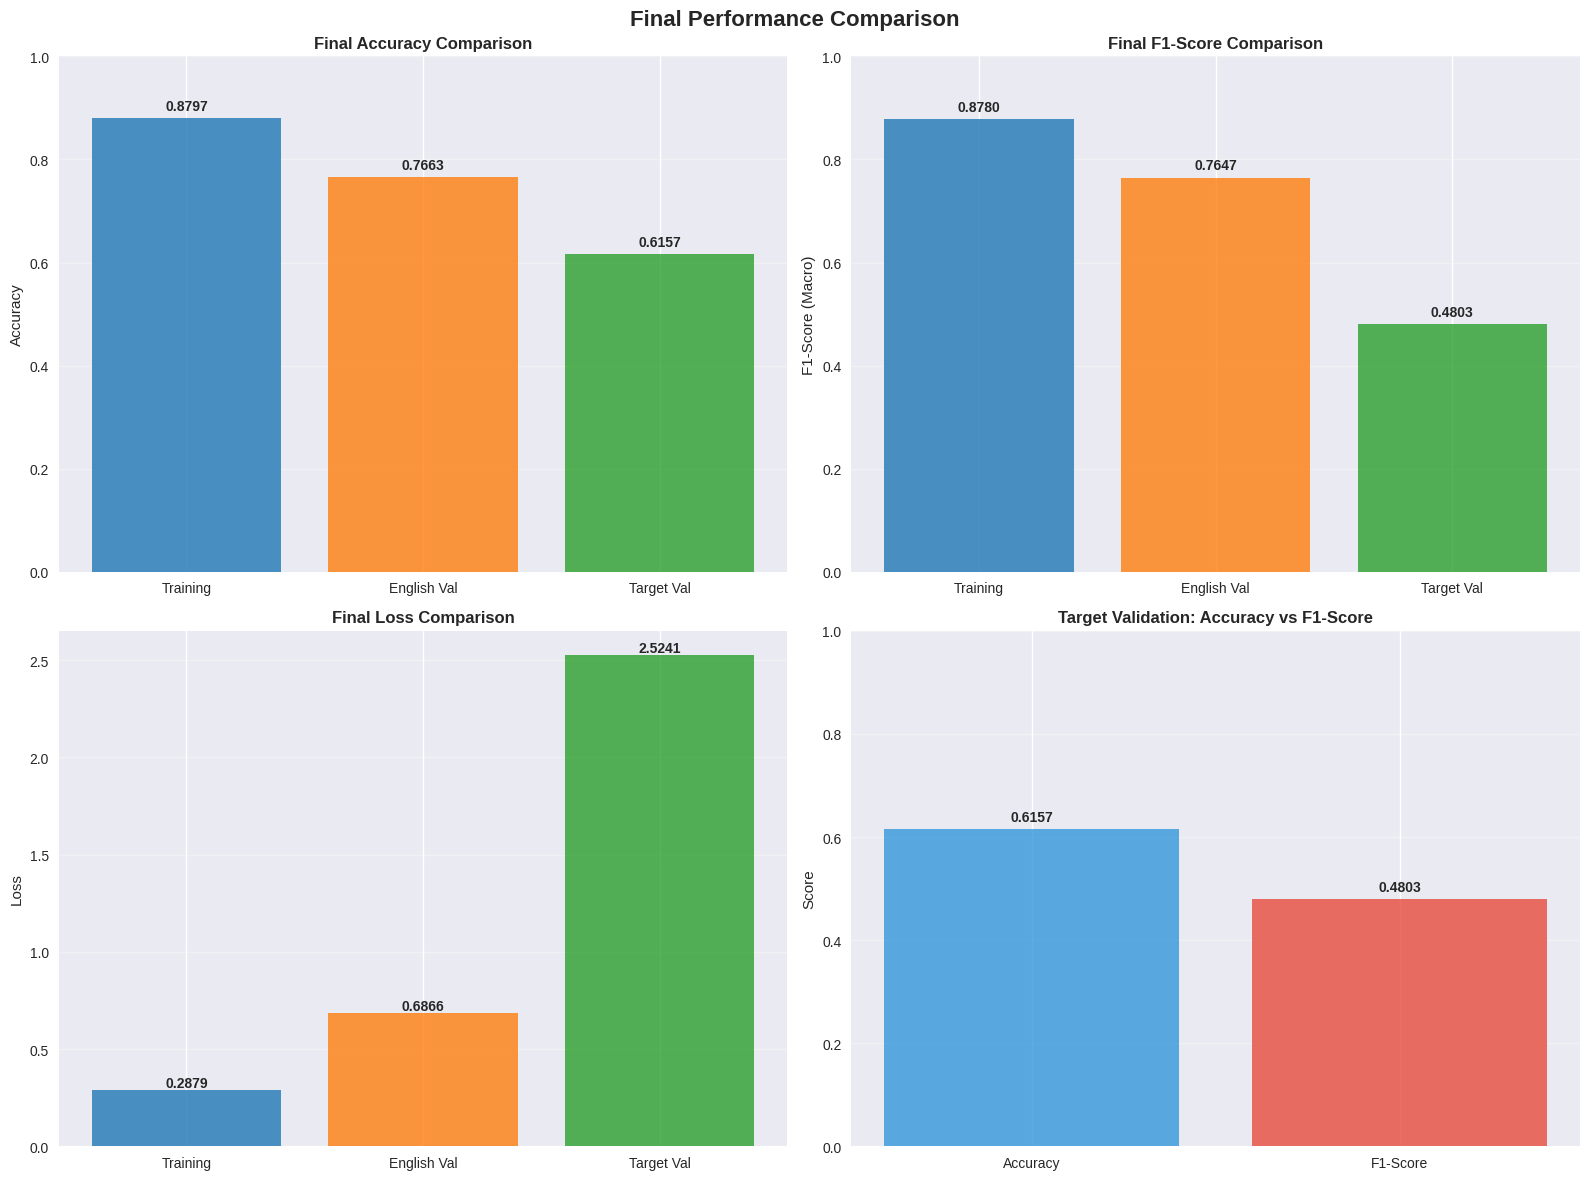

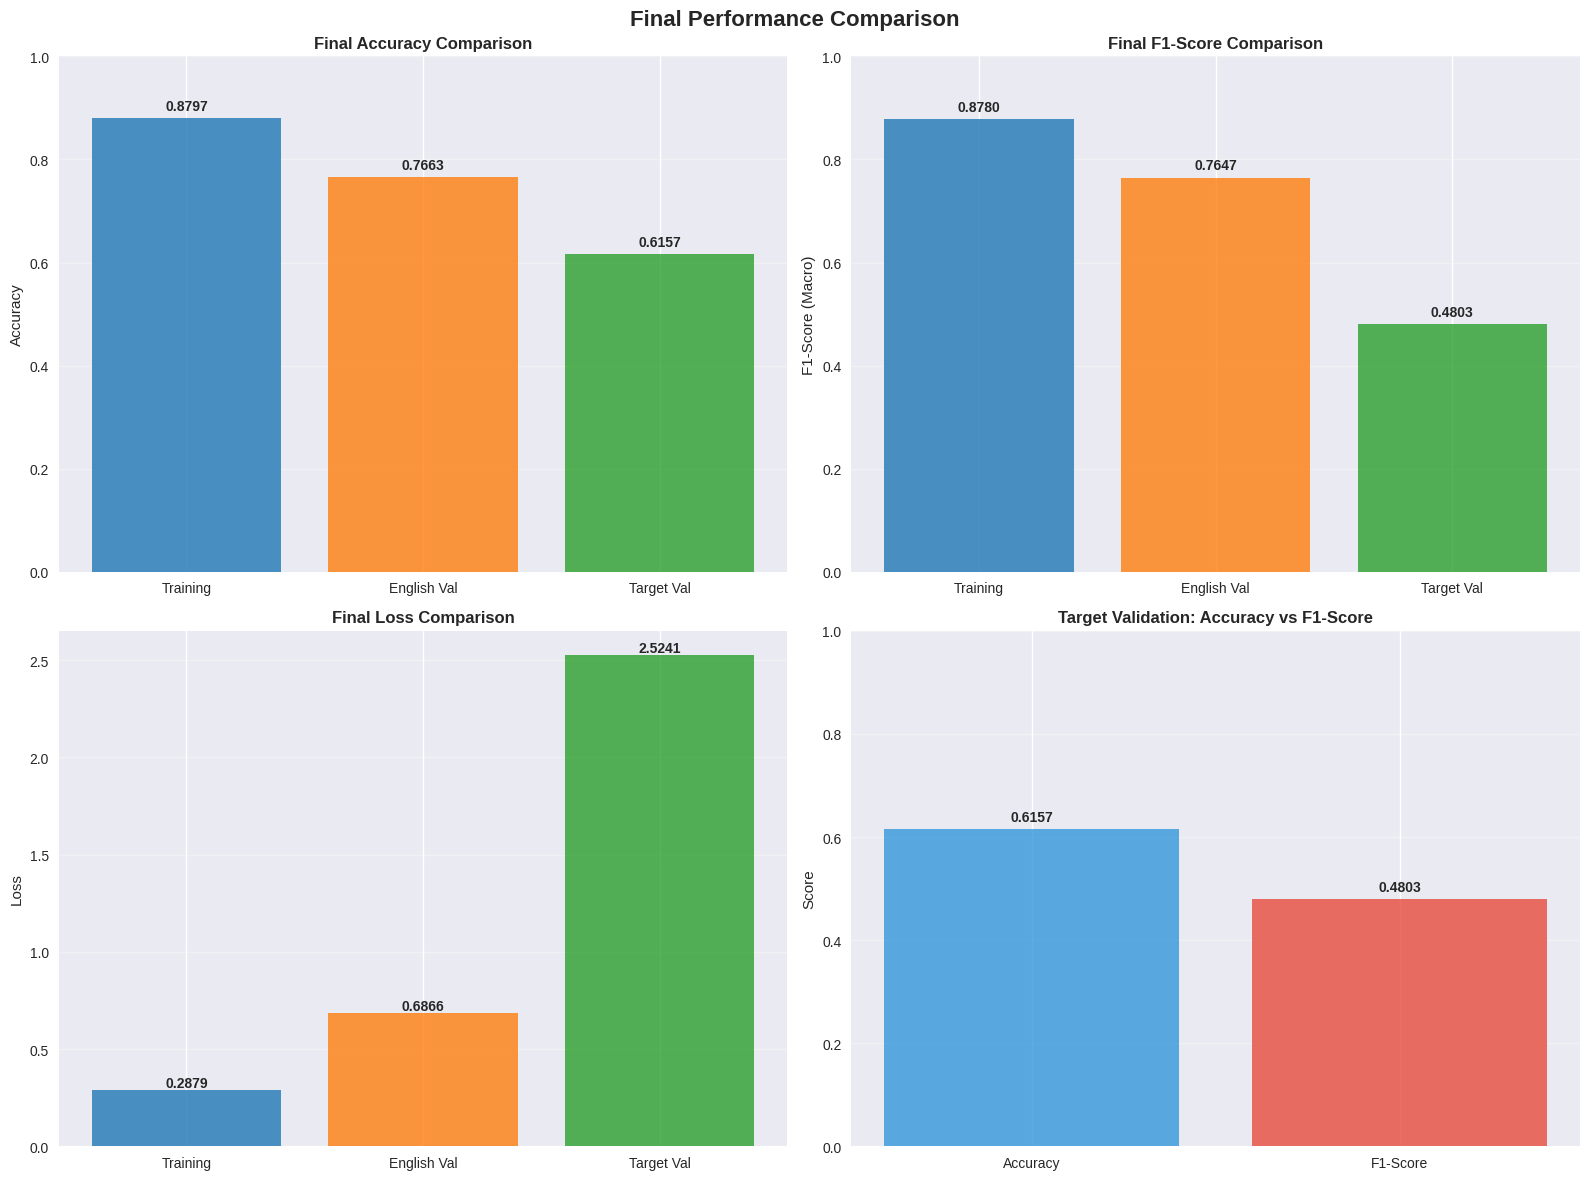

In [22]:
training_visualizer.plot_final_comparison(history)

Generating and saving all plots to plots/
Loss plot saved to plots/losses.png
Accuracy plot saved to plots/accuracies.png
F1-score plot saved to plots/f1_scores.png
Accuracy-F1 comparison plot saved to plots/accuracy_f1_comparison.png
Learning rate plot saved to plots/learning_rate.png
Transfer gap plot saved to plots/transfer_gap.png
Training dashboard saved to plots/dashboard.png
Final comparison saved to plots/final_comparison.png
All plots saved successfully!


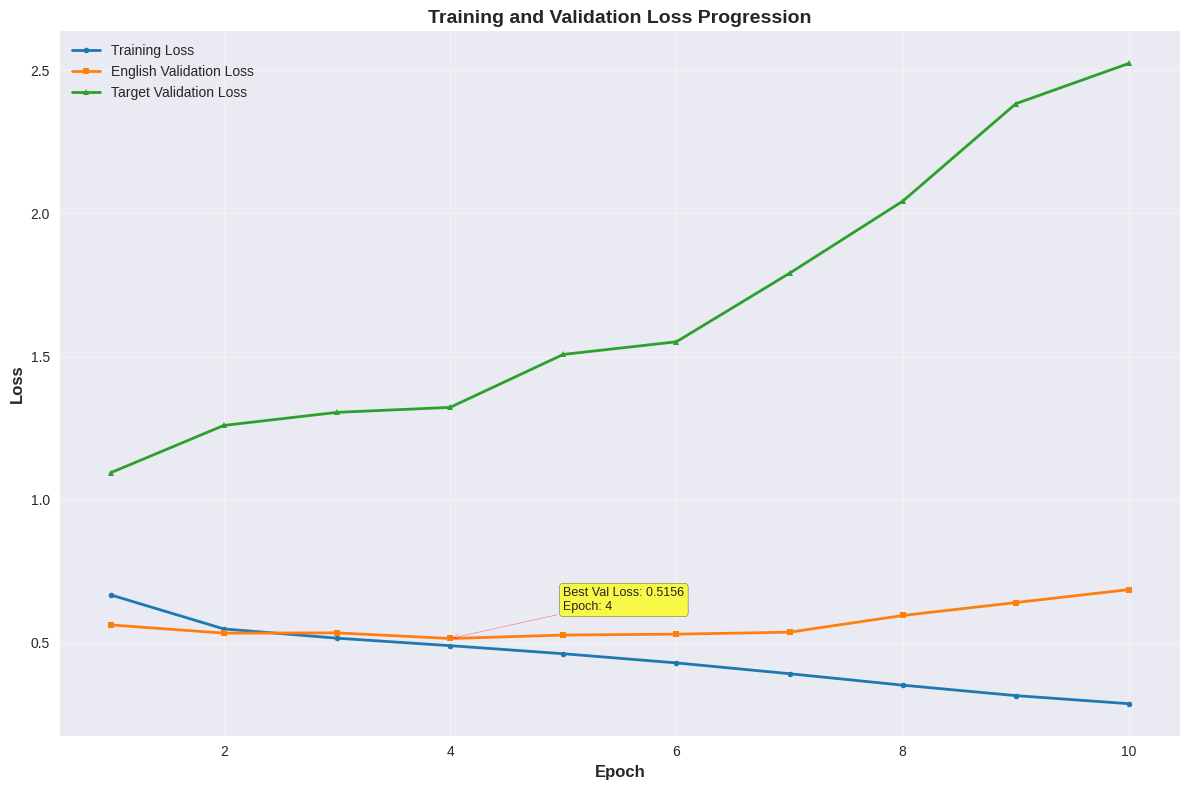

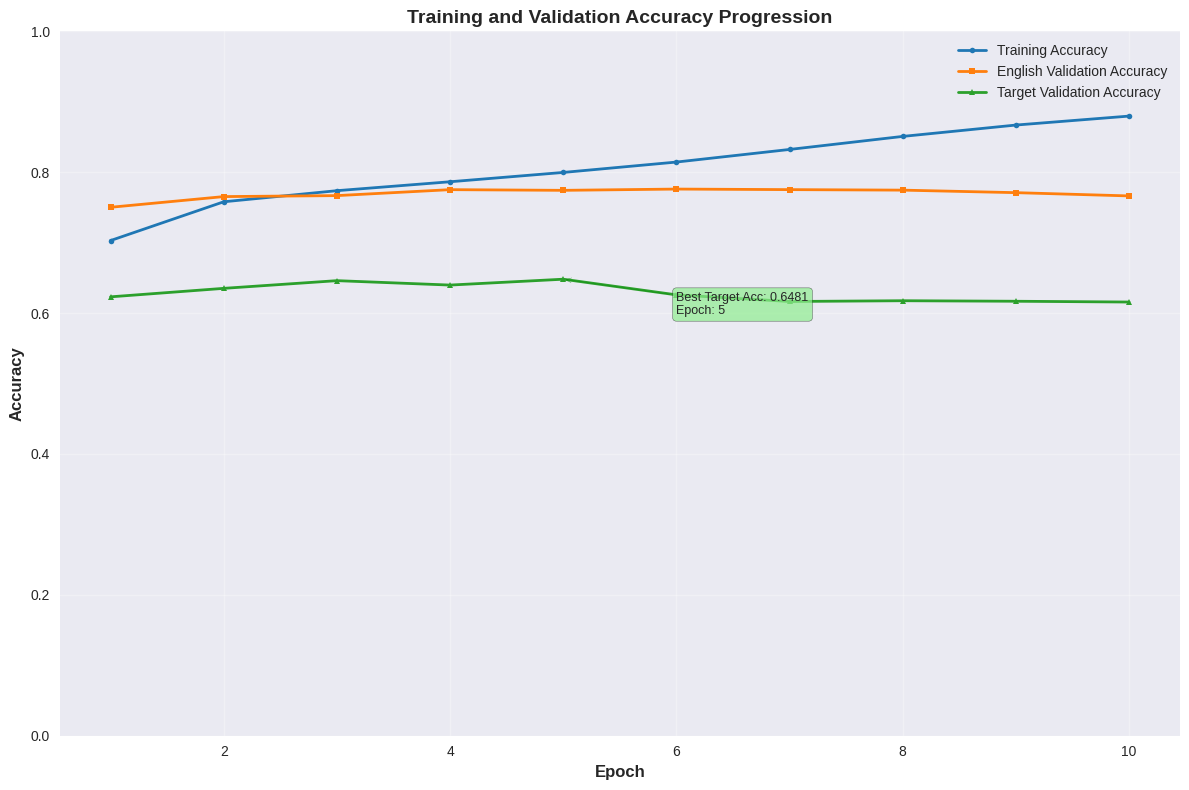

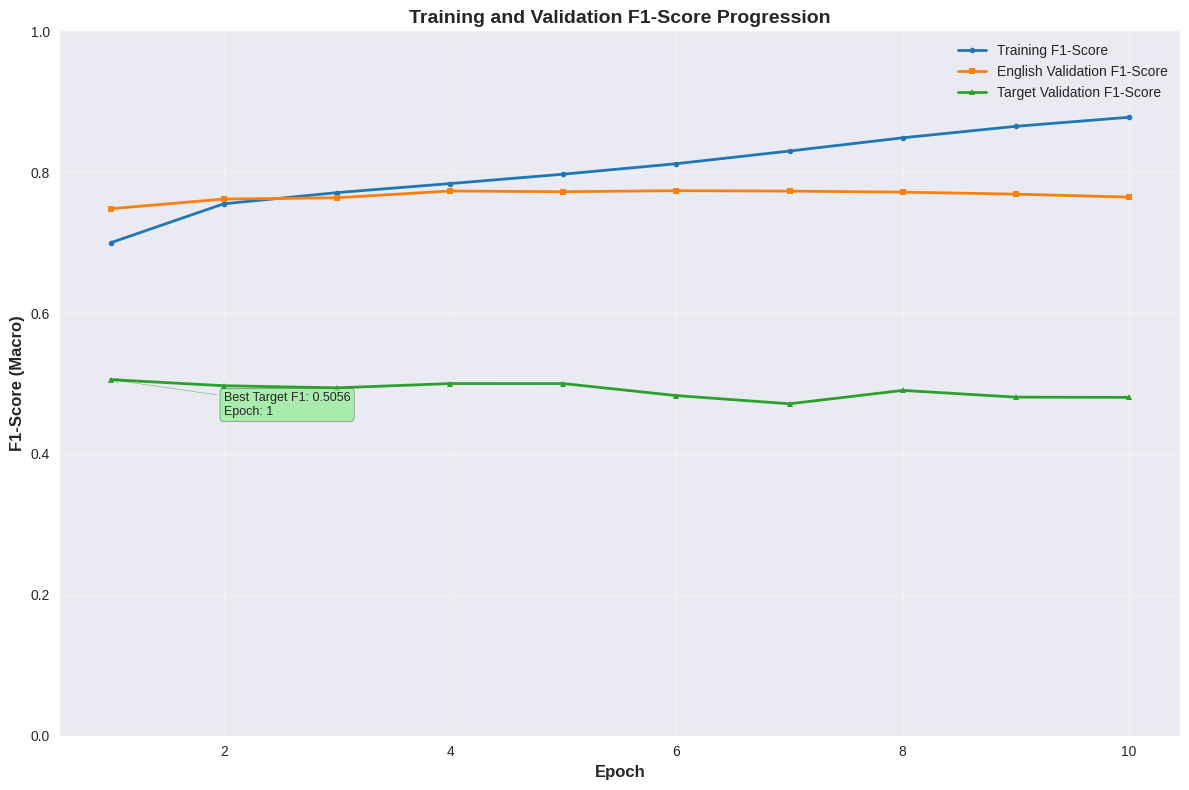

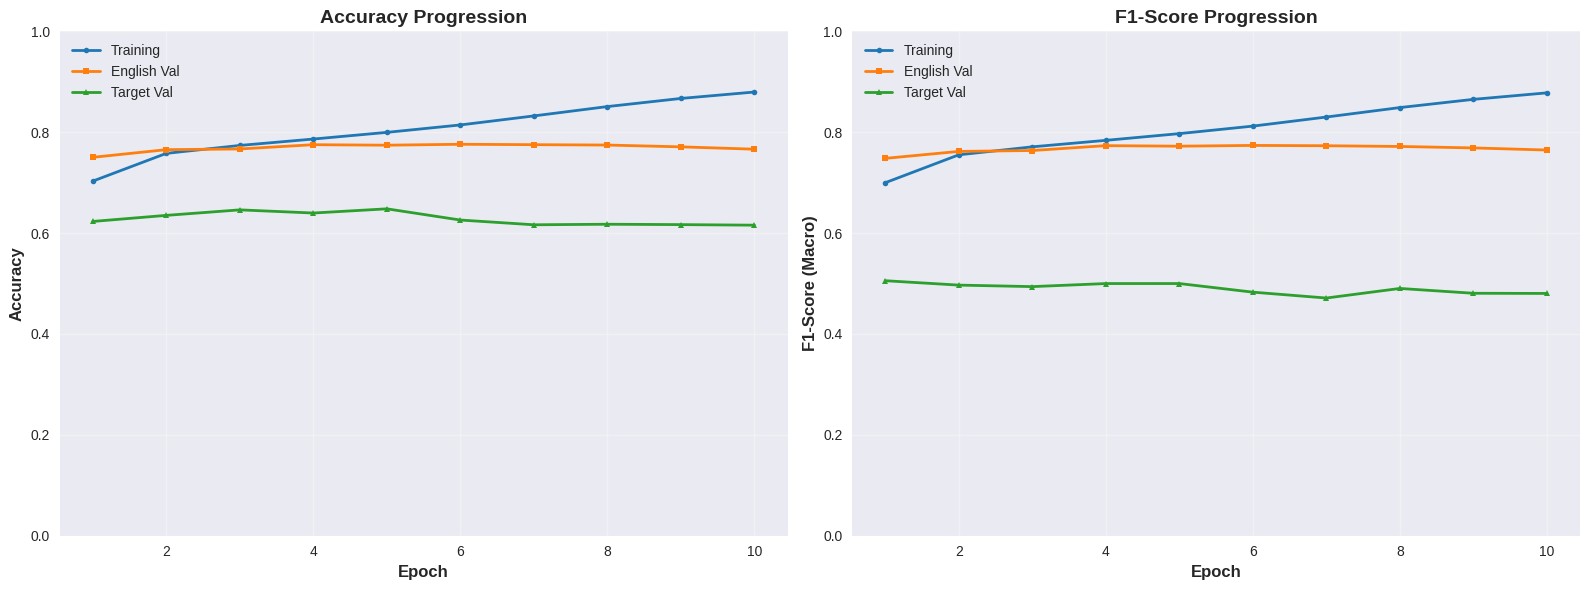

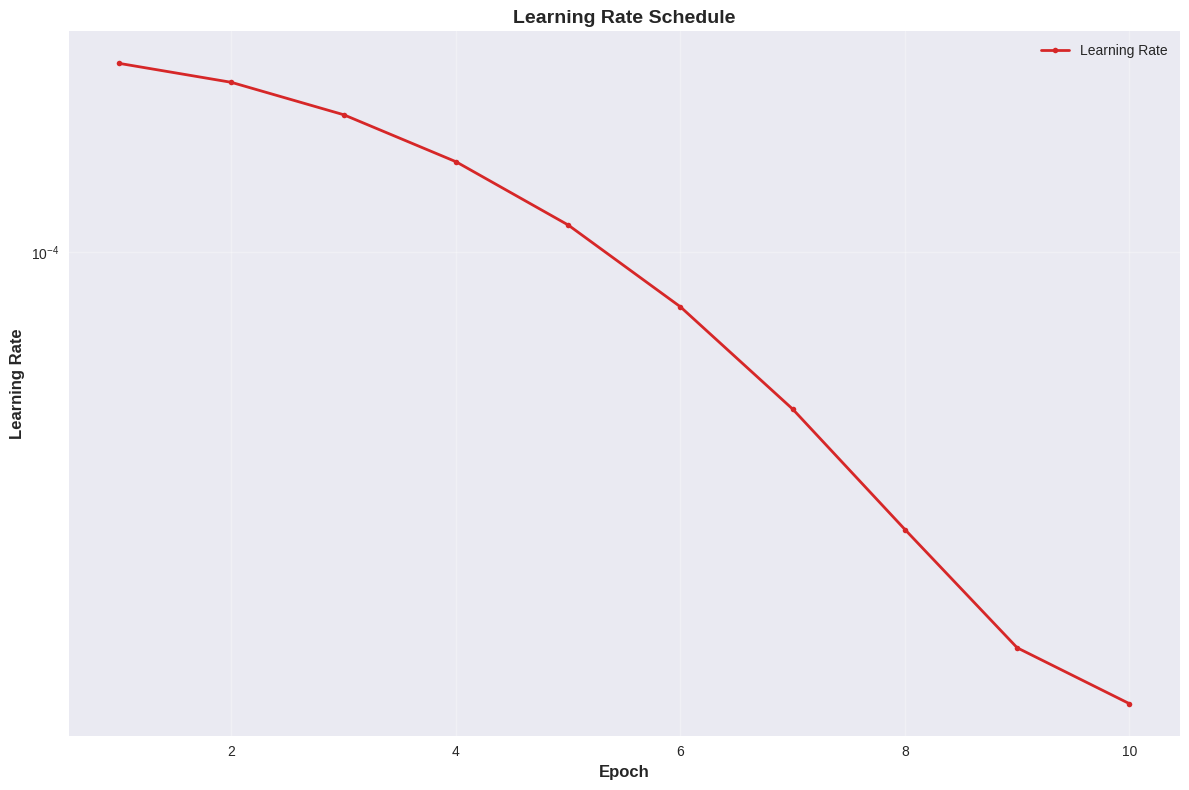

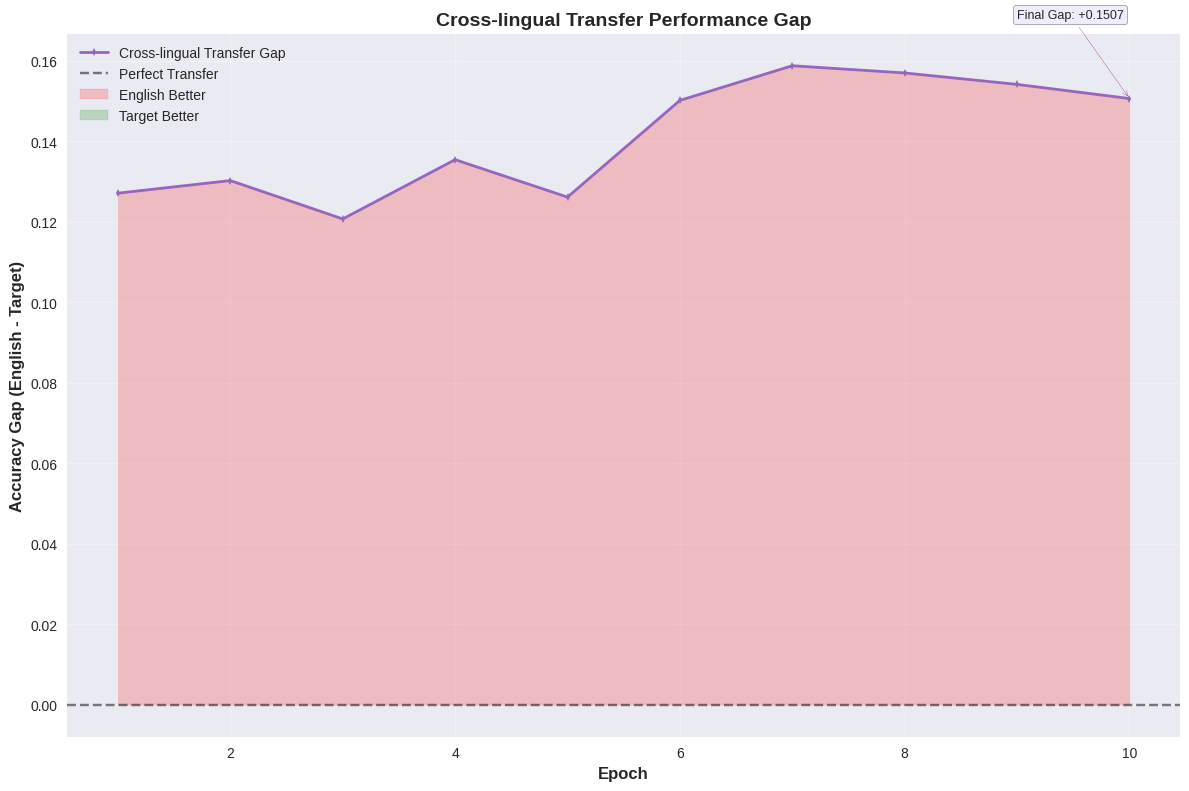

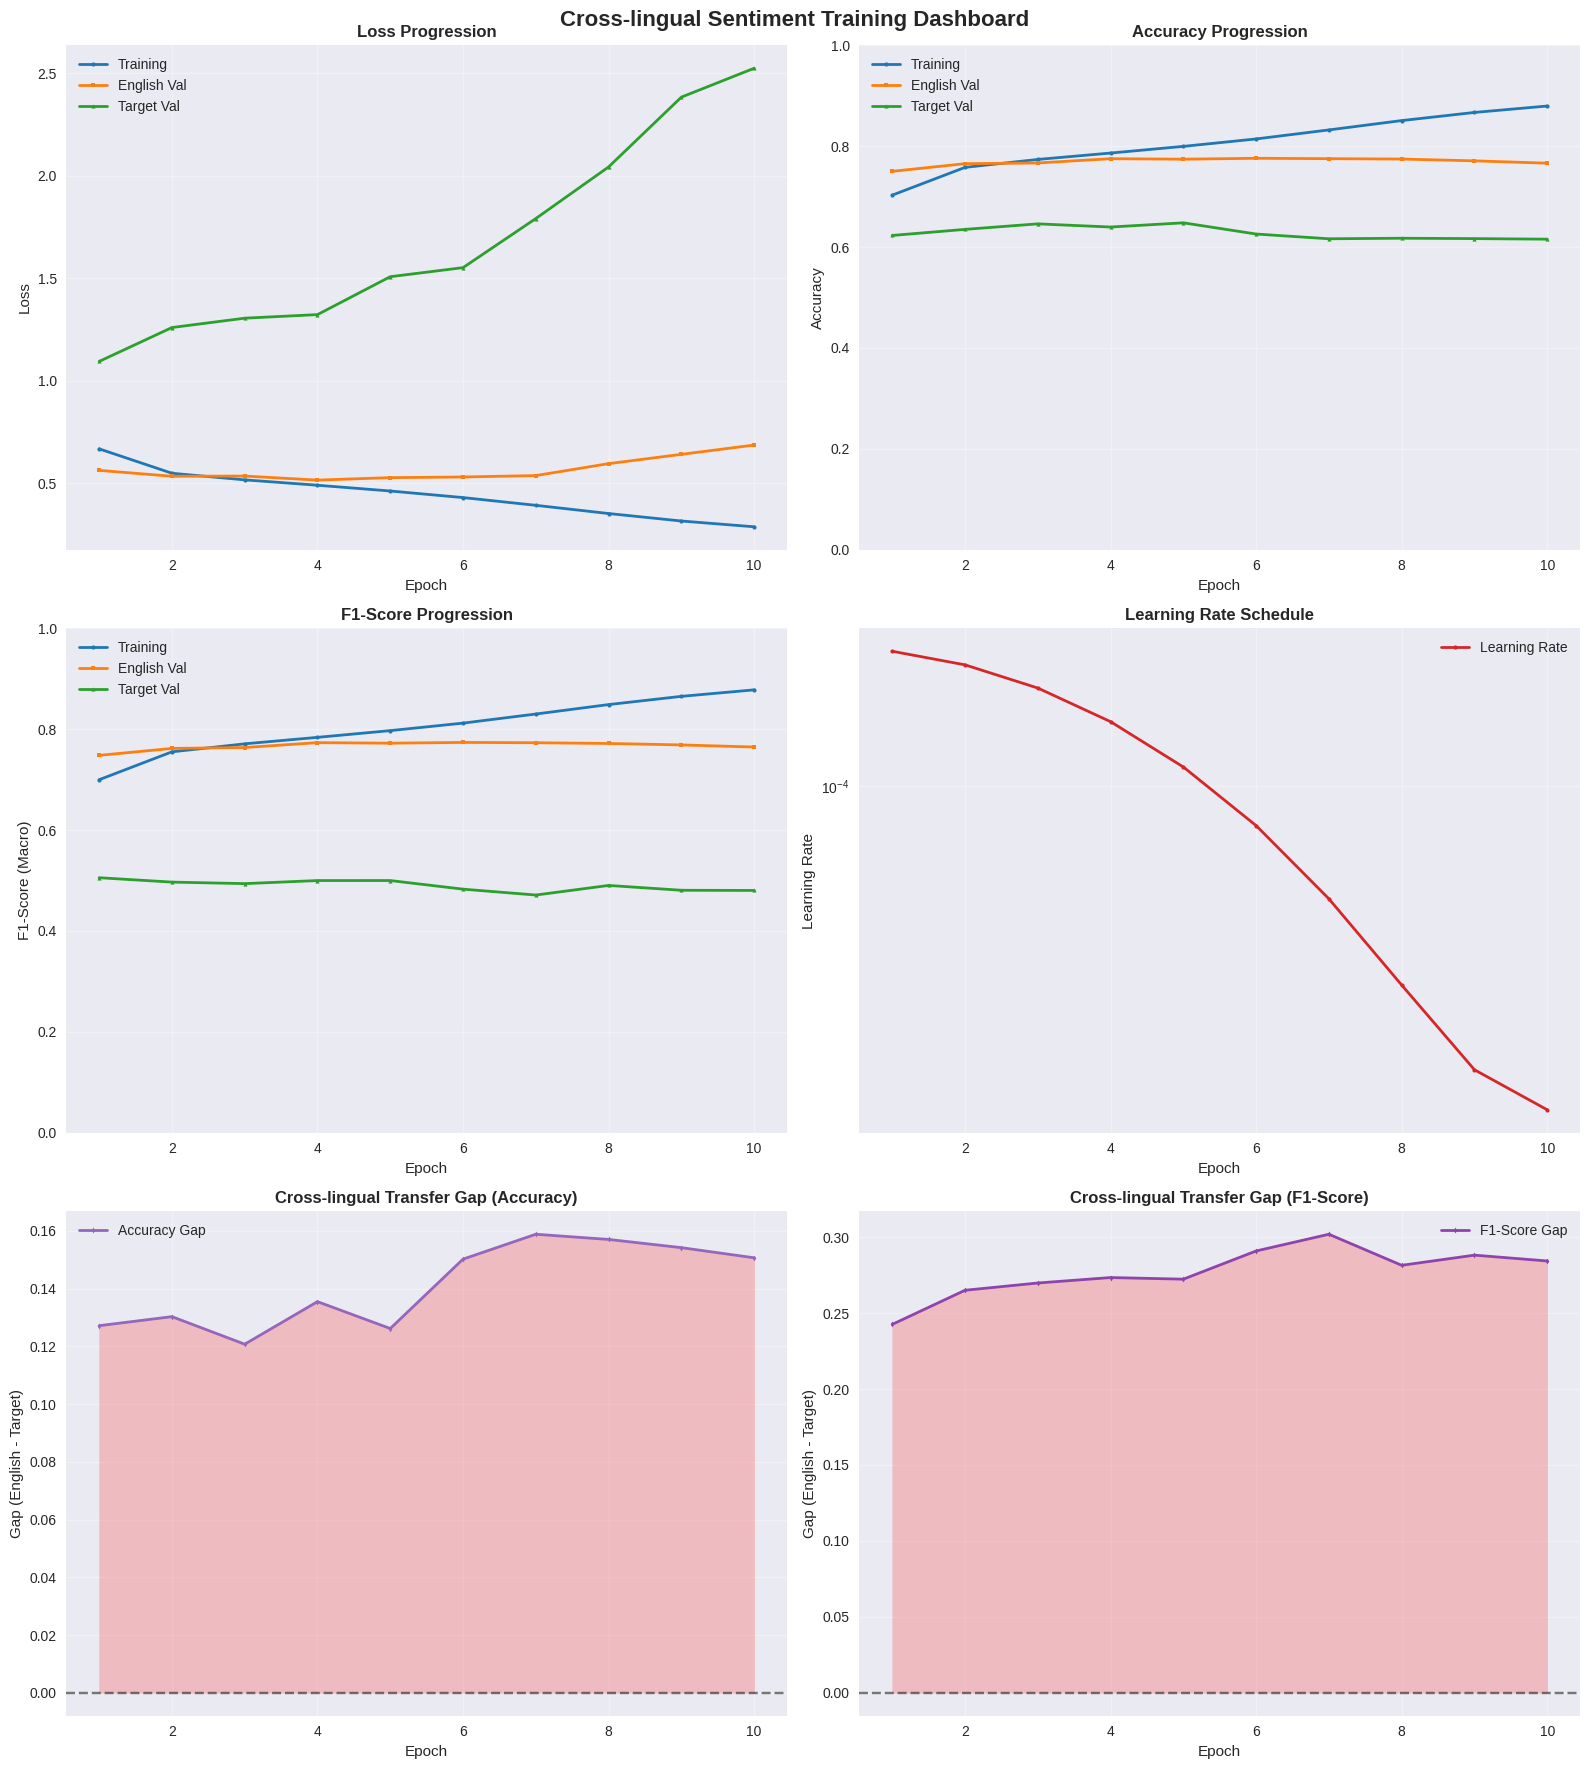

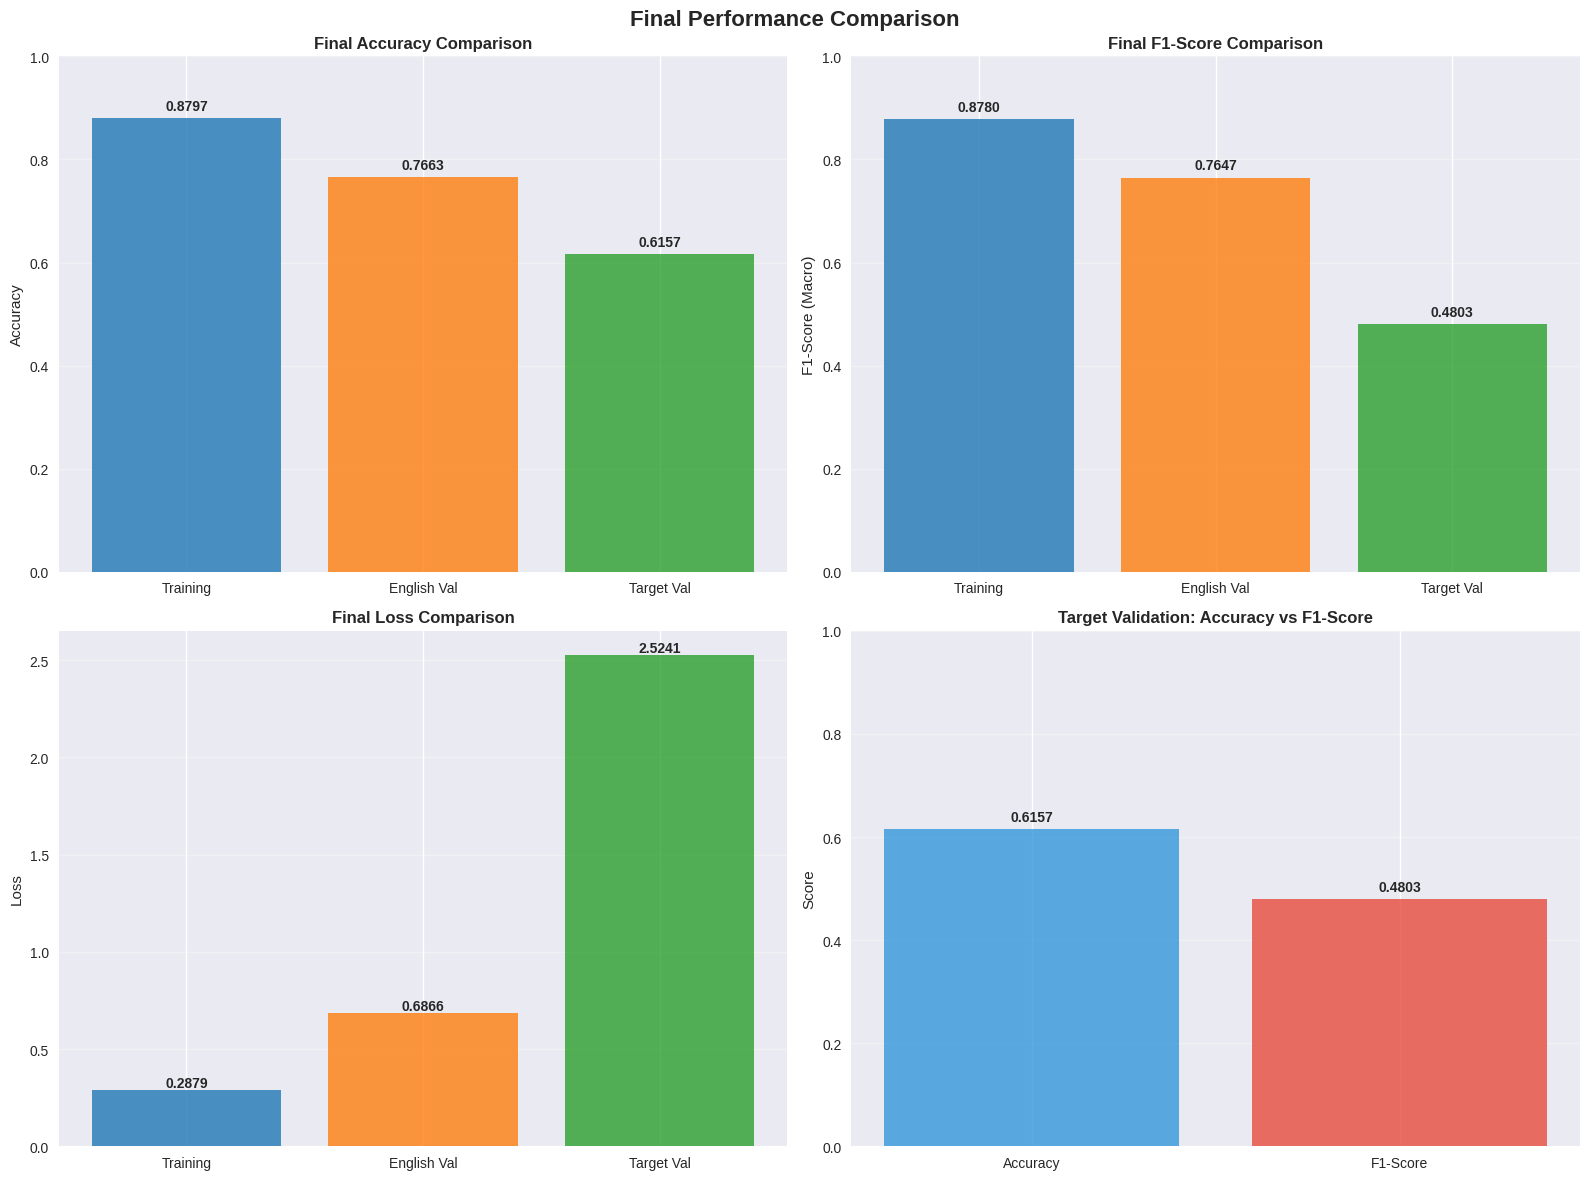

In [23]:
training_visualizer.save_all_plots(history)

Generating and saving all plots to plots/
Loss plot saved to plots/losses.png
Accuracy plot saved to plots/accuracies.png
F1-score plot saved to plots/f1_scores.png
Accuracy-F1 comparison plot saved to plots/accuracy_f1_comparison.png
Learning rate plot saved to plots/learning_rate.png
Transfer gap plot saved to plots/transfer_gap.png
Training dashboard saved to plots/dashboard.png
Final comparison saved to plots/final_comparison.png


Evaluating :   0%|          | 0/149 [00:00<?, ?it/s]

ROC curve saved to plots/roc_curve.png
All plots saved successfully!


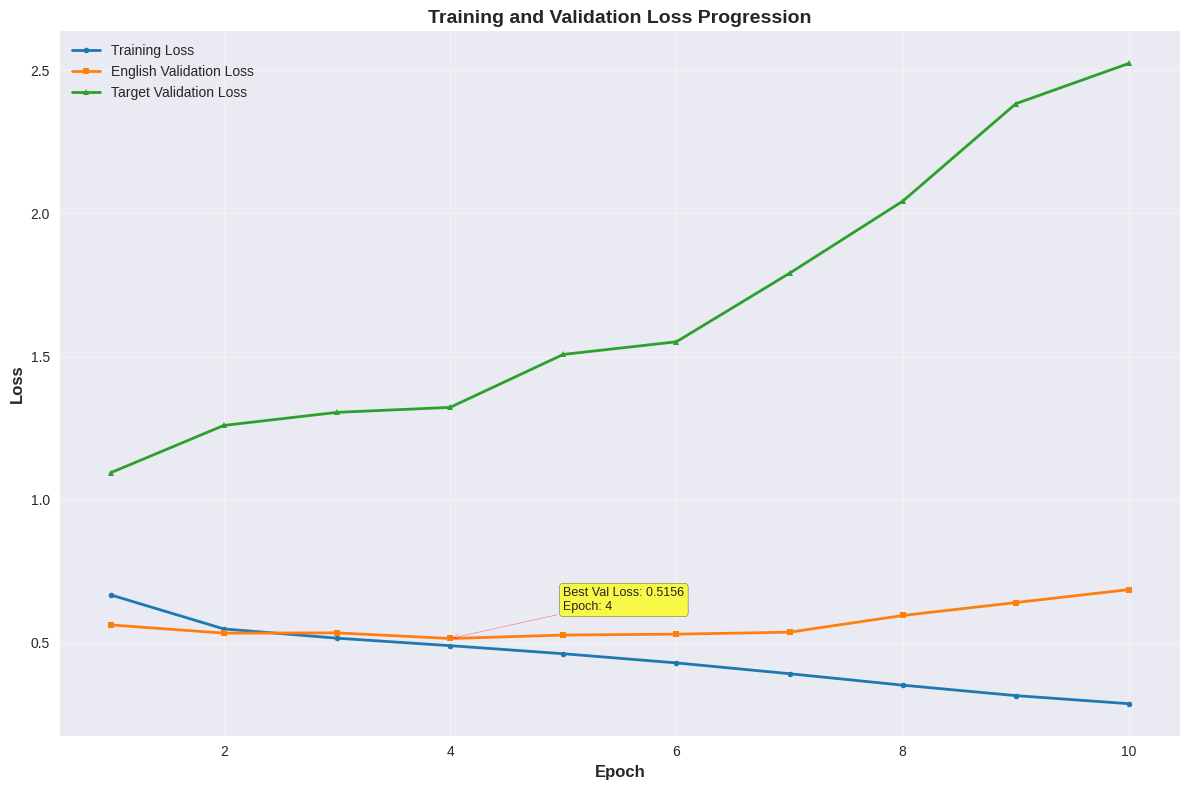

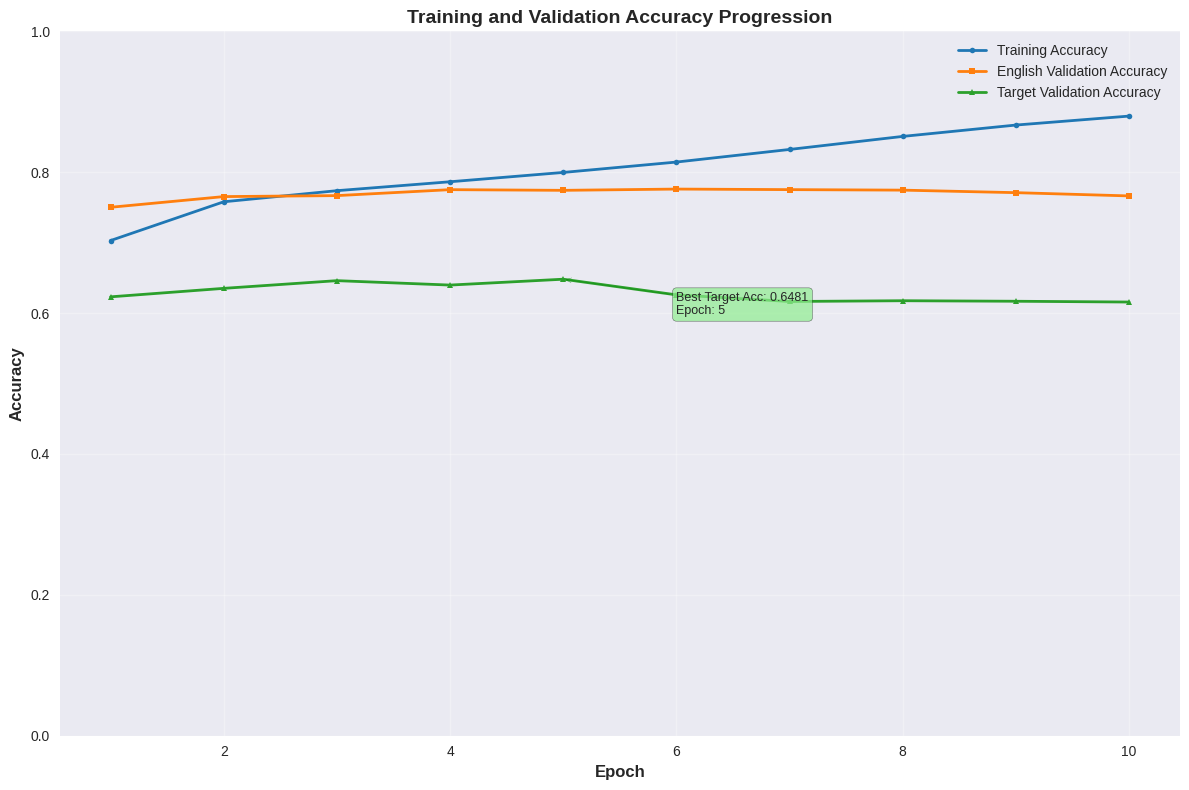

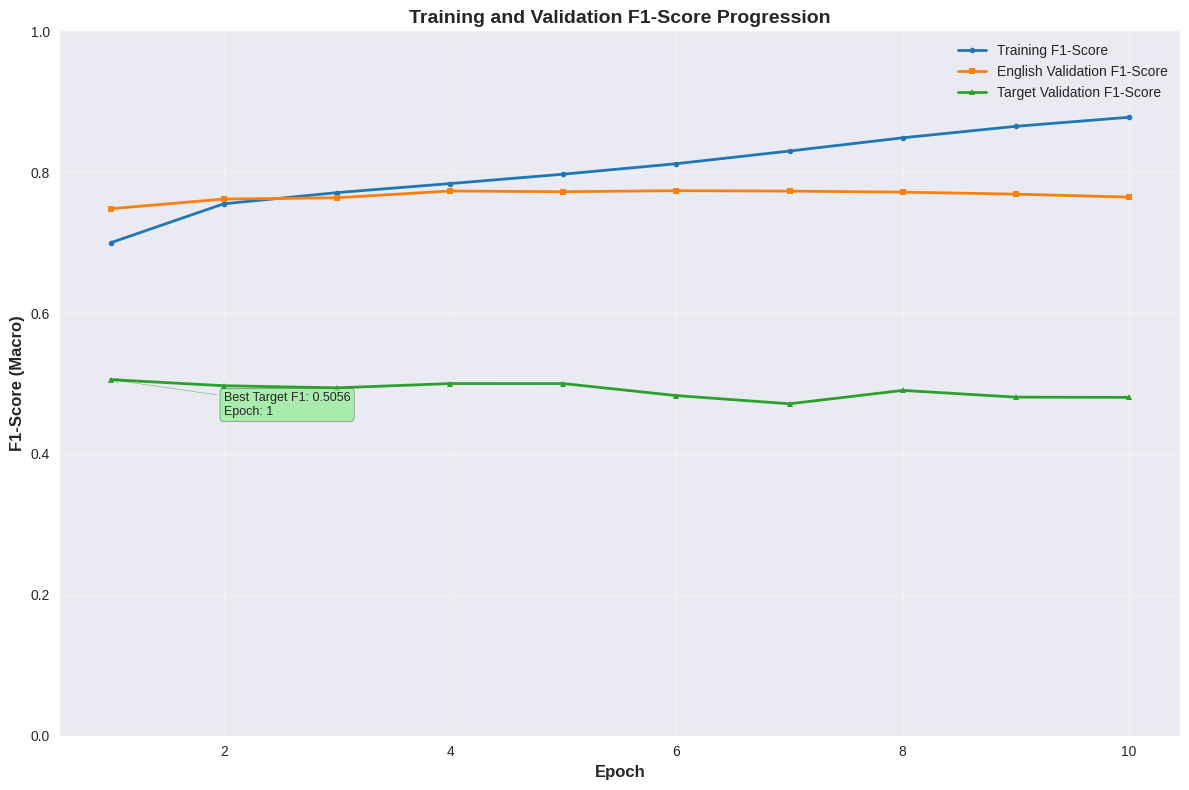

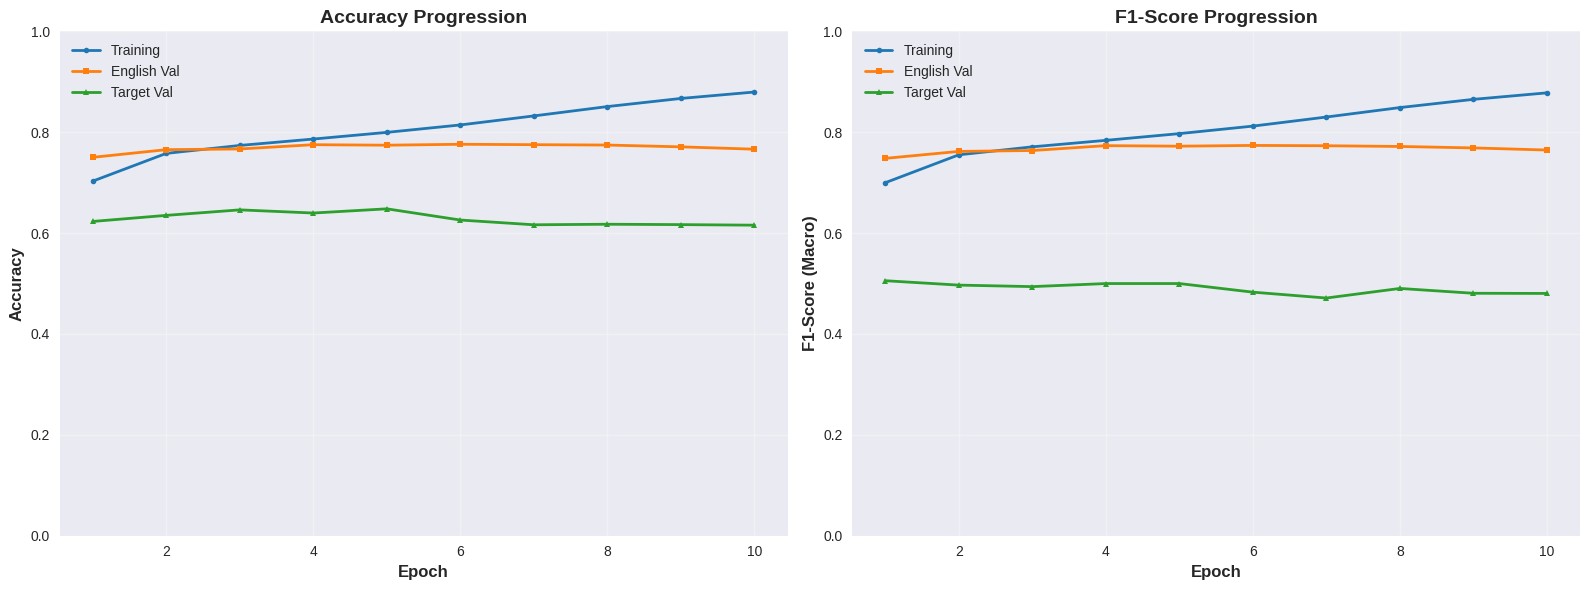

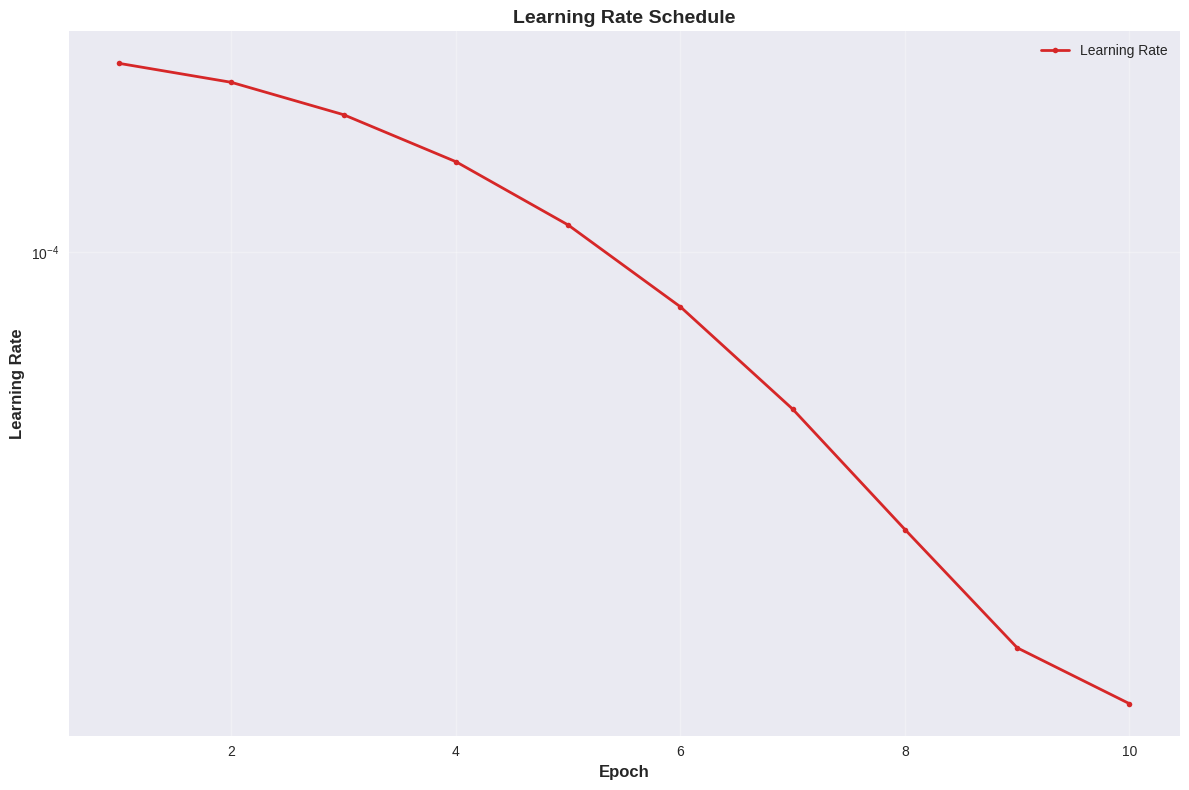

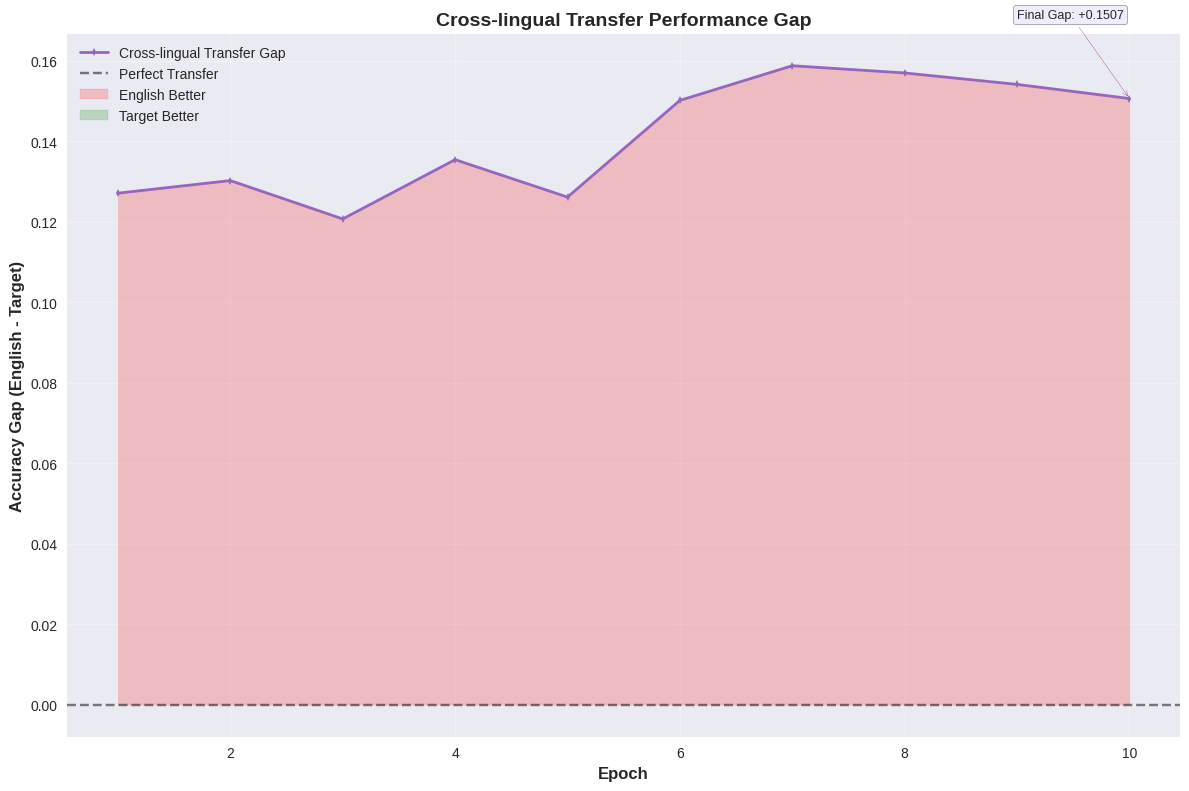

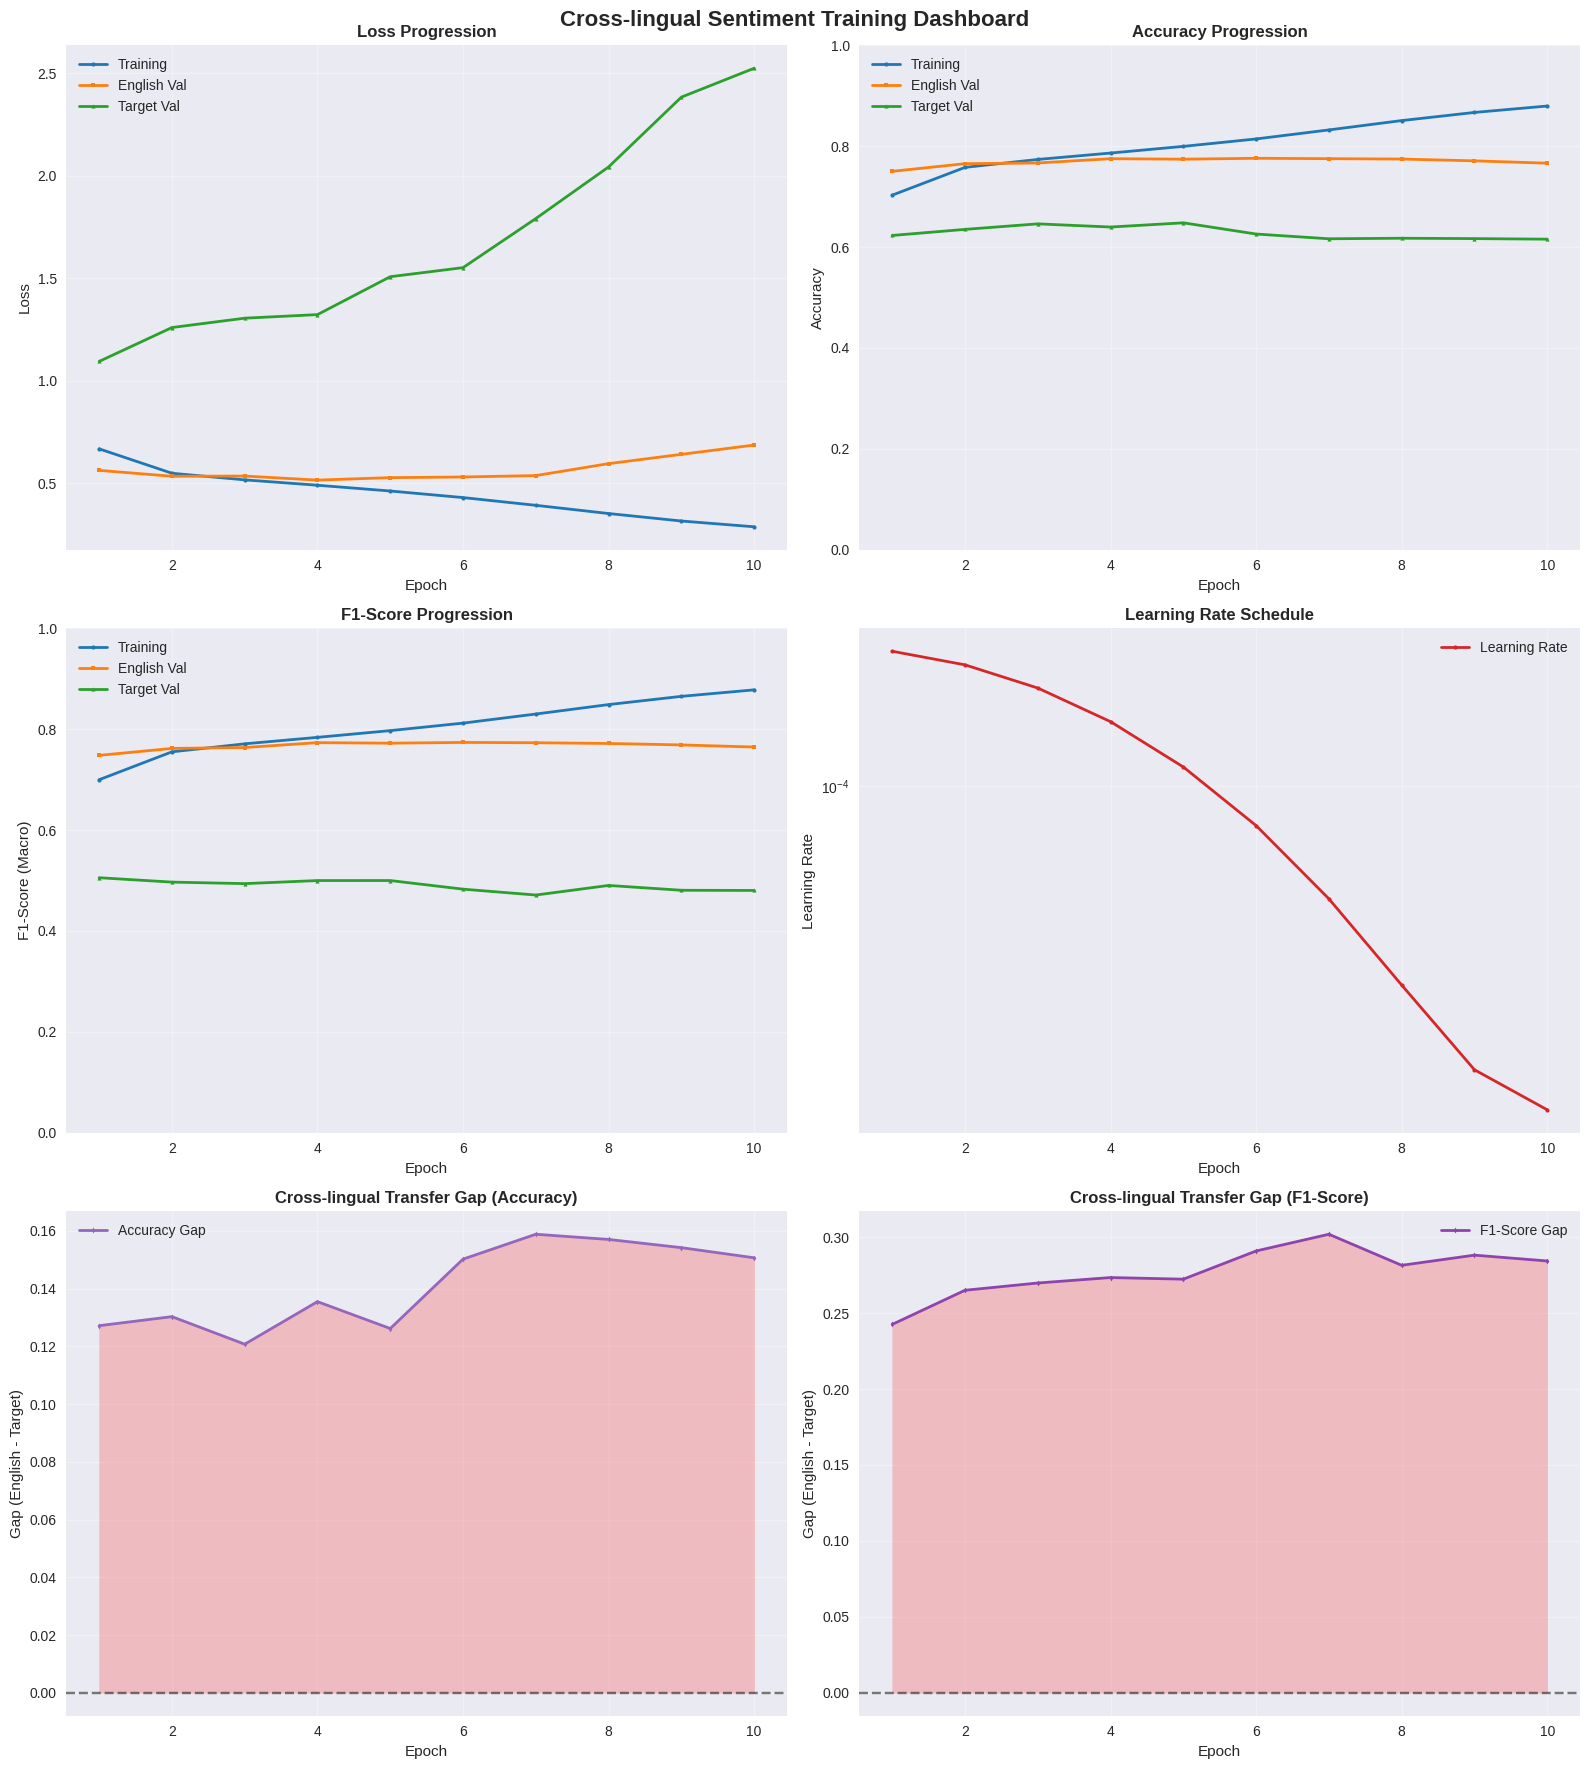

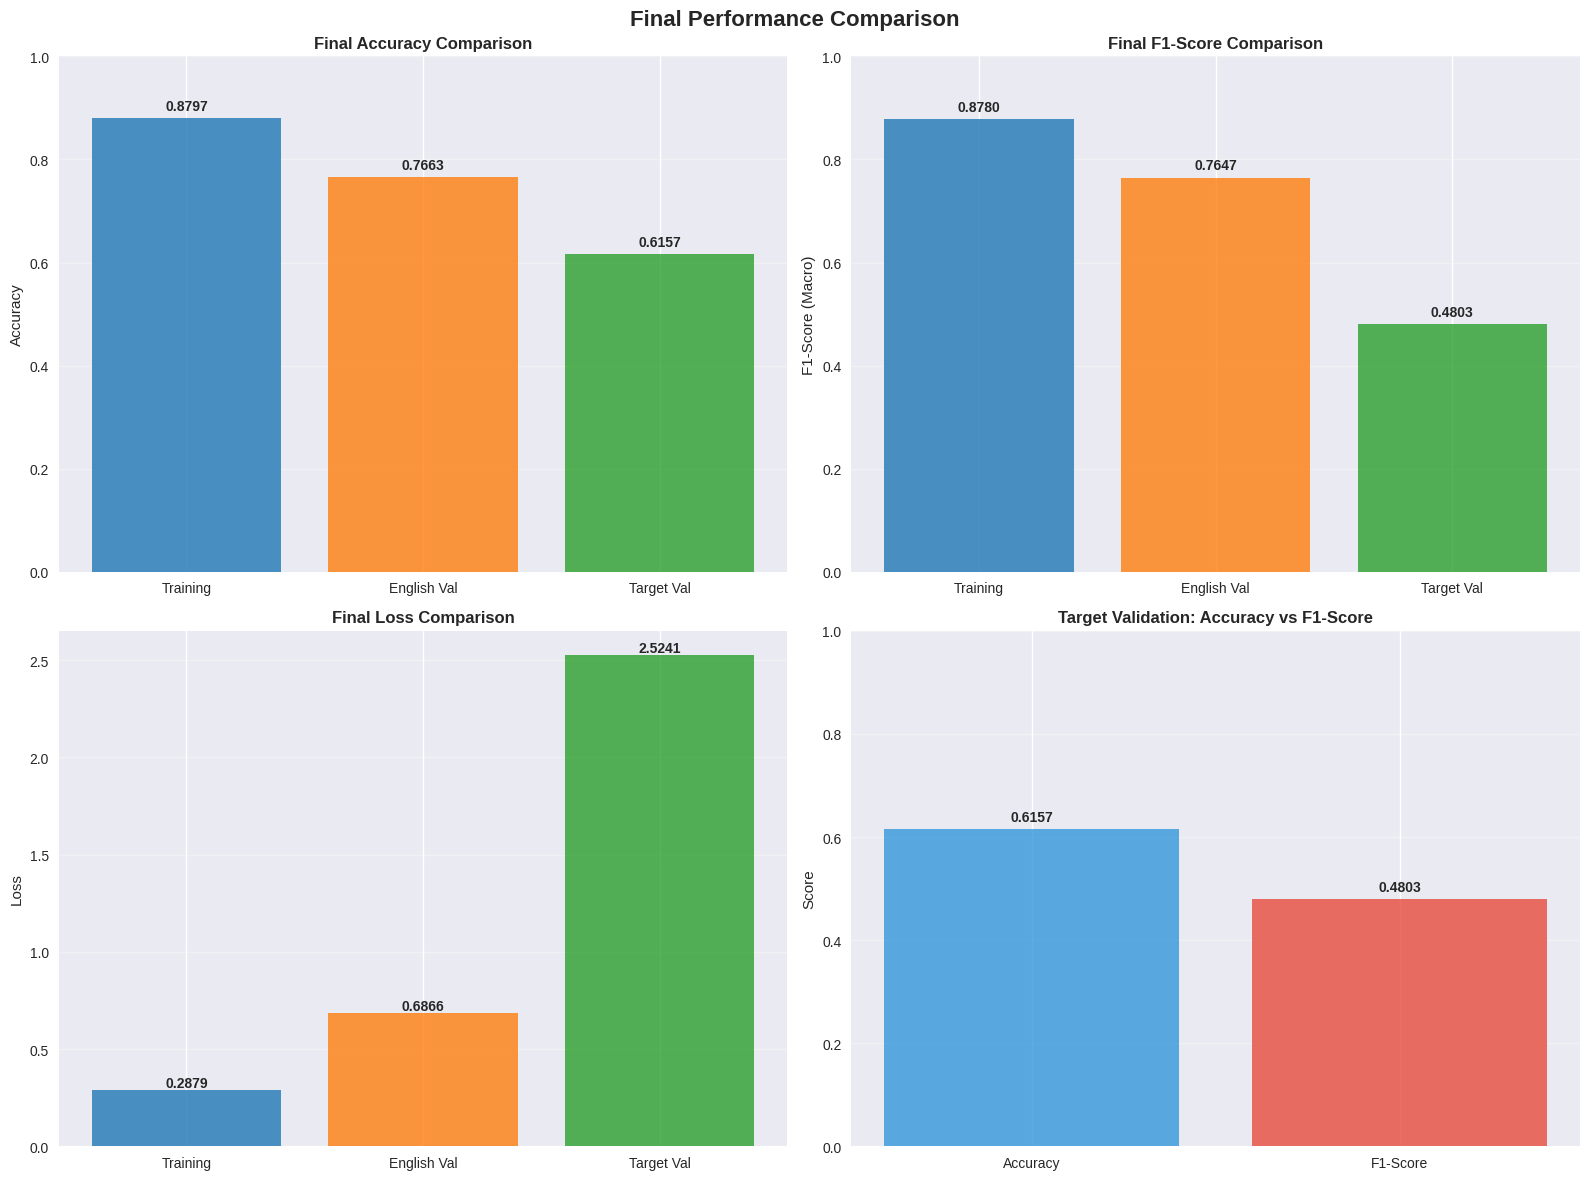

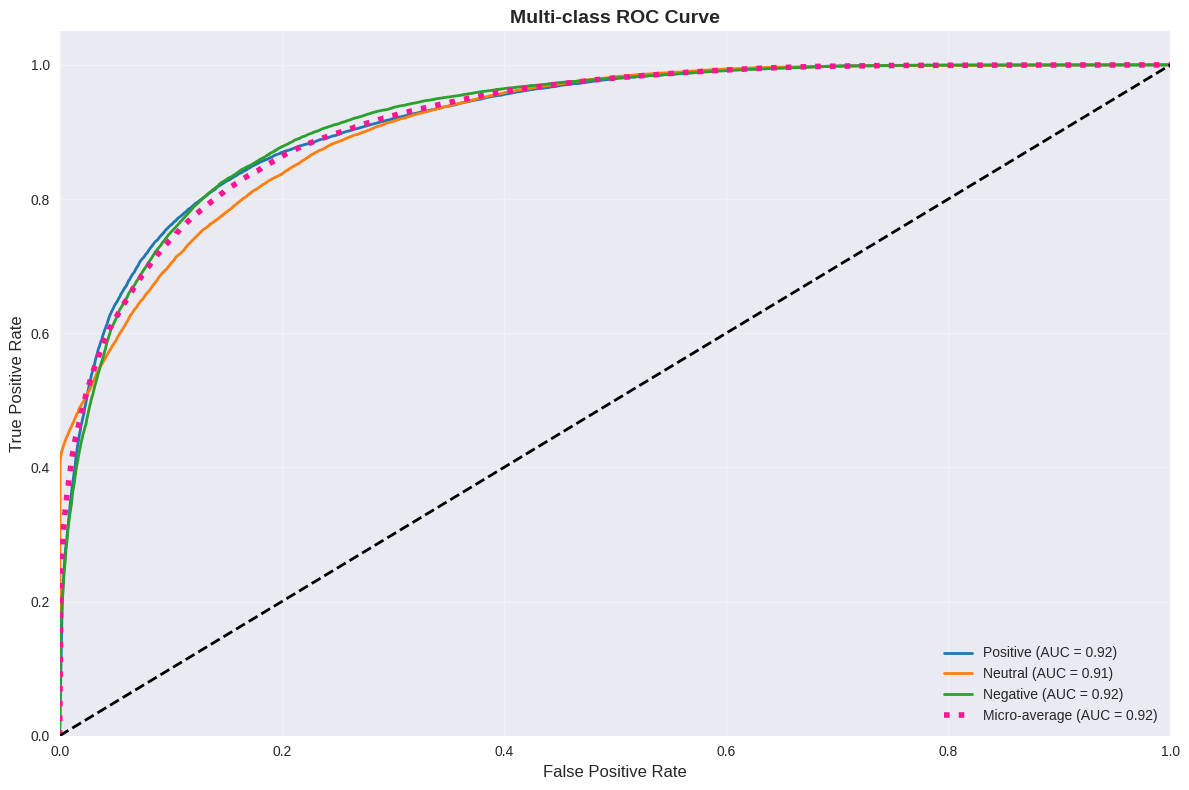

In [24]:
training_visualizer.save_all_plots(history, trainer)

In [25]:
import shutil

# This will create a zip file: /kaggle/working/working_dir.zip
shutil.make_archive('/kaggle/working/working_dir', 'zip', '/kaggle/working/')

'/kaggle/working/working_dir.zip'

In [26]:
# Zip the entire 'plots' folder
shutil.make_archive('/kaggle/working/plots_backup', 'zip', '/kaggle/working/plots')

'/kaggle/working/plots_backup.zip'